In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Theory

We have to initialize the King model at equilibrium.

## 1) Solve the King model's second-order ordinary differential equation

King models are a family of so-called "lowered isothermal spheres", defined by the distribution function:

$$
f_\text{King}(\mathcal{E}) \, = \, 
\begin{cases}
\rho_1 \left(2 \pi \sigma^2\right)^{-3/2} \left(e^{\mathcal{E}/\sigma^2} - 1\right) \, , &\mathcal{E}>0\\
0 \, , & \mathcal{E} \leq 0
\end{cases} \:\: ,
$$

where:
- $\mathcal{E} = \psi(r) - \frac{1}{2}v^2$ is the relative energy,
- $\psi(r) = \phi(r_\text{truncation}) - \phi(r)$ is the relative potential, such that $\psi(r_\text{truncation})=0$,
- $\sigma$ is a velocity scale parameter and is NOT the velocity dispersion,
- $\rho_1$ is a density scale parameter and is NOT the central density $\rho_0$.

The density as a function of the relative potential is:

$\rho(\psi) \, = \, \rho_1 \left[ e^{\psi/\sigma^2} \text{erf}\left(\dfrac{\sqrt{\psi}}{\sigma}\right) - \sqrt{\dfrac{4 \psi}{\pi \sigma^2}} \left(1+\dfrac{2 \psi}{3 \sigma^2}\right) \right] \, = \, \rho_1 \hat{\rho}(\psi) \:, \:$ where $\hat{\rho}(\psi)$ is the dimensionless density.

We have to solve Poisson's equation for the King model:

$\dfrac{1}{r^2} \dfrac{d}{dr} \left(r^2 \dfrac{d\psi}{dr}\right) \, = \, -4 \pi G \rho(r) \, = \, 
-4 \pi G \rho_1 \left[ e^{\psi/\sigma^2} \text{erf}\left(\dfrac{\sqrt{\psi}}{\sigma}\right) - \sqrt{\dfrac{4 \psi}{\pi \sigma^2}} \left(1+\dfrac{2 \psi}{3 \sigma^2}\right) \right] \:.$

It can be expressed in terms of dimensionless quantities: 

$W(r) \doteq \dfrac{\psi(r)}{\sigma^2}\:\:$ , $\:\:x(r) \doteq \dfrac{r}{r_0}$ , where $r_0 = \sqrt{\dfrac{9 \sigma^2}{4 \pi G \rho_0}}$ and $\rho_0$ is the central density.

$\dfrac{1}{x^2} \dfrac{d}{dx} \left(x^2 \dfrac{dW}{dx}\right) \, = \, 
\dfrac{2}{x} \dfrac{dW}{dx} + \dfrac{d^2W}{dx^2} \, = \,
-9 \dfrac{\rho_1}{\rho_0} \left[ e^{W(x)} \text{erf}\left(\sqrt{W(x)}\right) - \sqrt{\dfrac{4 W(x)}{\pi}} \left(1+\dfrac{2 W(x)}{3}\right) \right] \:.$

We set the following boundary conditions: $W(r=0) = W_0\:$ , $\:W'(r=0) = 0$.\
It appears that $W_0 = 9$ is a fine approximation of elliptical galaxies.

Finally, the central density is $\rho_0 = \rho_1 \hat{\rho}(W_0) \:\: \Longrightarrow \:\: \dfrac{\rho_1}{\rho_0} = \dfrac{1}{\hat{\rho}(W_0)} \:\:,\:\: \dfrac{\rho(W)}{\rho_0} = \dfrac{\hat{\rho}(W)}{\hat{\rho}(W_0)}$.

In [2]:
from scipy.integrate import solve_ivp
from scipy.special import erf

def Dimensionless_density(W):
    return np.exp(W) * erf(np.sqrt(W)) - np.sqrt(4 * W / np.pi) * (1 + 2 * W / 3)

# Define the right-hand side of the King model ODE system
def King_rhs(x, y, W0=9.0):
    W, dWdx = y
    
    # Stop the integration beyond the truncation radius
    if W <= 0:
        return [0, 0]  

    # RHS of the Poisson equation (dimensionless form)
    ddWdx2 = -9 * Dimensionless_density(W) / Dimensionless_density(W0) - 2 * dWdx / x
    
    # Avoid the singularity at x = 0
    if x == 0:
        dWdx = 0

    return [dWdx, ddWdx2]


# Integrate the King model for a given central potential W0
def Solve_King_Model(W0=9.0, x_min=1e-5, x_max=1000.0, num=int(1e6)):
    # Generate logarithmically-spaced x-values to span many orders of magnitude
    x_vals = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=num)
    
    # Set the initial conditions: W(0) = W0 , W'(0) = 0
    y0 = [W0, 0.0]  

    # Integrate the ODE
    sol = solve_ivp(
        King_rhs,
        t_span=(x_min, x_max),
        y0=y0,
        t_eval=x_vals,
        method='RK45',
        rtol=1e-8,
        atol=1e-10,
        args=(W0,))

    # Extract the dimensionless radius and the dimensionless potential
    x = sol.t
    W = sol.y[0]

    # Compute the dimensionless density
    mask = W > 0
    dimensionless_rho = np.zeros_like(W)
    dimensionless_rho[mask] = Dimensionless_density(W[mask]) / Dimensionless_density(W0)

    return x, W, dimensionless_rho

In [3]:
W0 = 9.0  # central potential
x, W, dimensionless_rho = Solve_King_Model(W0)

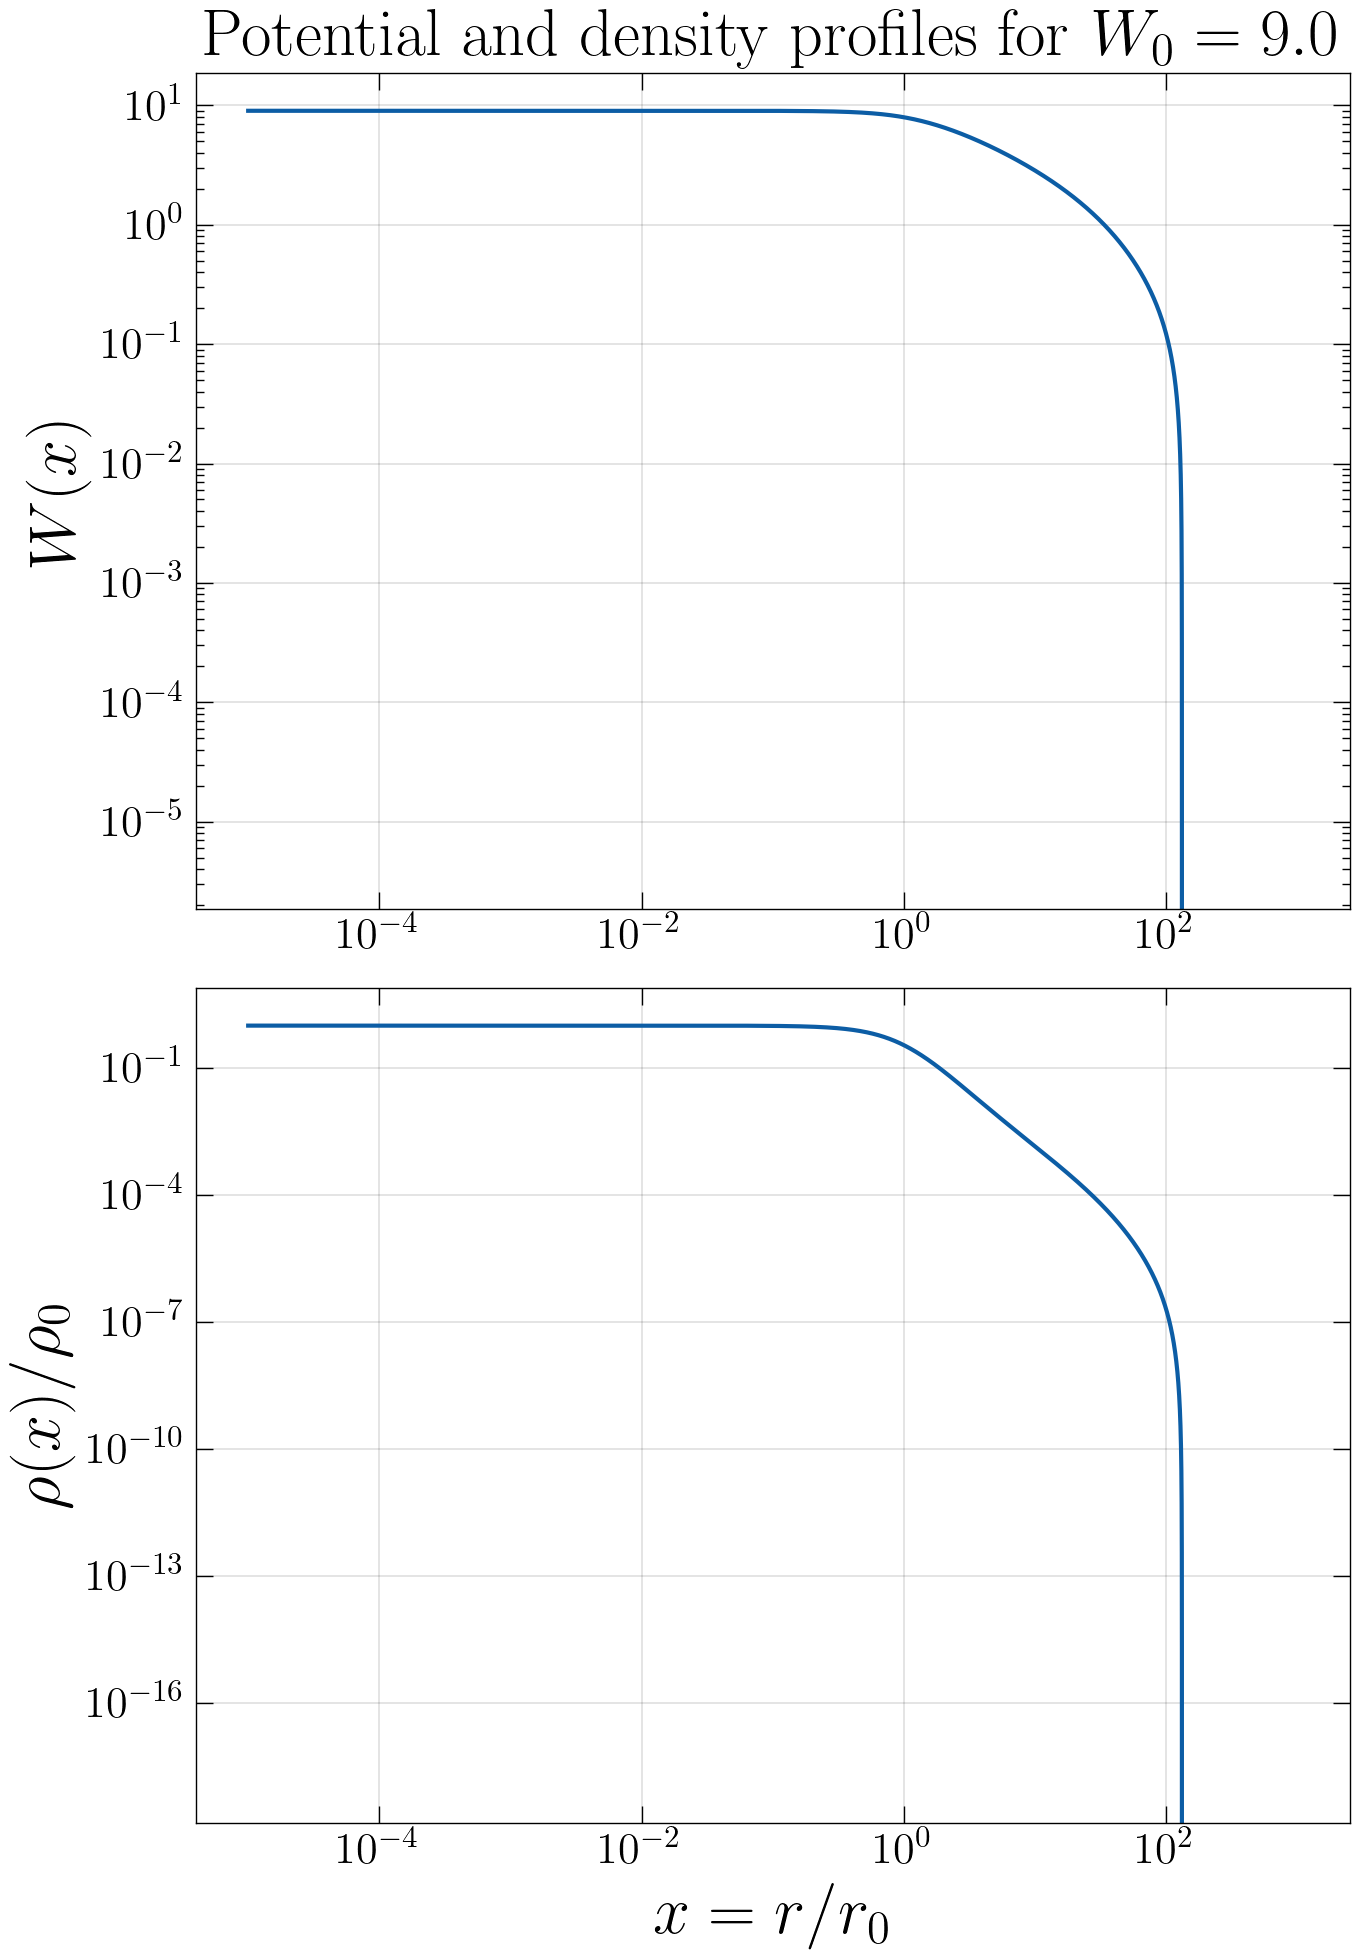

In [4]:
plt.figure(figsize=(7, 10))
plt.subplot(2, 1, 1)
plt.plot(x, W)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$W(x)$')
plt.title(f'Potential and density profiles for $W_0 = {W0}$')

plt.subplot(2, 1, 2)
plt.plot(x, dimensionless_rho)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x = r / r_0$')
plt.ylabel('$\\rho(x) / \\rho_0$')

plt.tight_layout()
plt.show()

## 2) Positions

For the sampling of $\phi$ and $\theta$ we can apply the direct Monte Carlo sampling method.\
$\phi$ and $\theta$ are distributed uniformly on the surface of a sphere, so we sample $P \in [0,1]$ and then substitute it in:

$$p(\phi) = \dfrac{1}{2\pi} \:\: \Longrightarrow \:\: P(\phi) \, = \, \int^{\phi}_{0} p(\phi')d\phi' \, = \, \int^{\phi}_{0} \dfrac{1}{2\pi}d\phi' \, = \, \dfrac{\phi}{2\pi} \:\: \Longrightarrow \:\: {\color{lime} \large \phi(P) = 2\pi P} \:\:.$$

$$p(\theta) = \dfrac{\sin{\theta}}{2} \:\: \Longrightarrow \:\: P(\theta) \, = \, \int^{\theta}_{0} p(\theta')d\theta' \, = \, \int^{\theta}_{0} \dfrac{\sin{\theta'}}{2}d\theta' \, = \, \dfrac{1-\cos{\theta}}{2} \:\: \Longrightarrow \:\: {\color{lime} \large \theta(P) = \arccos(1-2P)} \:\:.$$

The sampling of the radial positions according to the King model is more tricky.

We know that the radial *pdf* $p(r)$ is given by: $p(r) \, = \, \dfrac{4\pi r^2 \rho(r)}{M_\text{tot}} \:\:.$

However, we only know $\rho(r) / \rho_0$ and so we have to manually normalize $p(r)$.

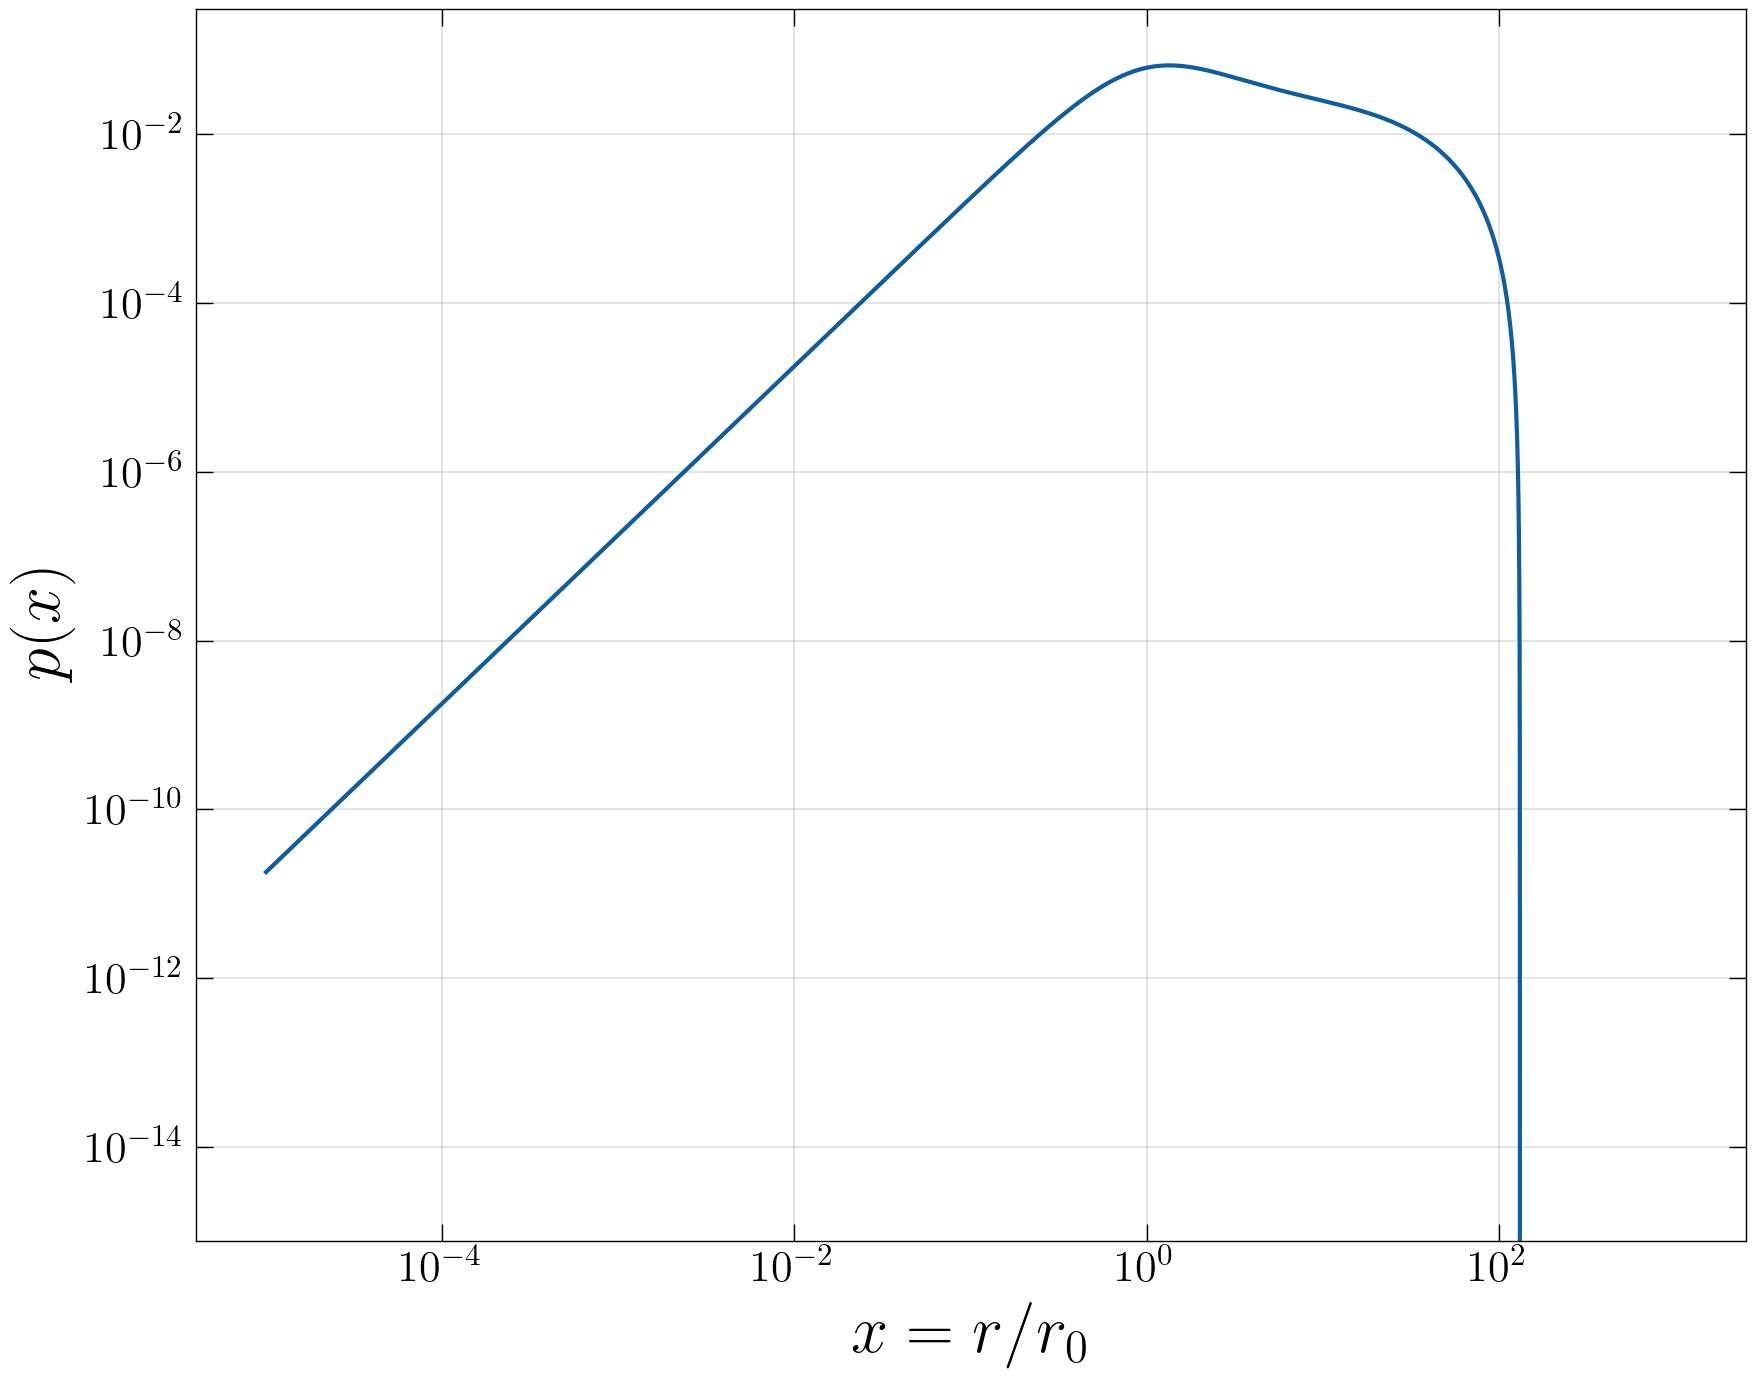

In [5]:
from scipy.integrate import simps

pdf = x**2 * dimensionless_rho

normalization = simps(pdf, x)
pdf /= normalization  # Normalize the PDF

plt.plot(x, pdf)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x = r / r_0$')
plt.ylabel('$p(x)$');

We would like to rescale $p(x)$ such that 75% of the sampled particles is within 5 internal units.\
In order to achieve this, we have to compute the cumulative.

100%|██████████| 999999/999999 [00:00<00:00, 2231633.73it/s]


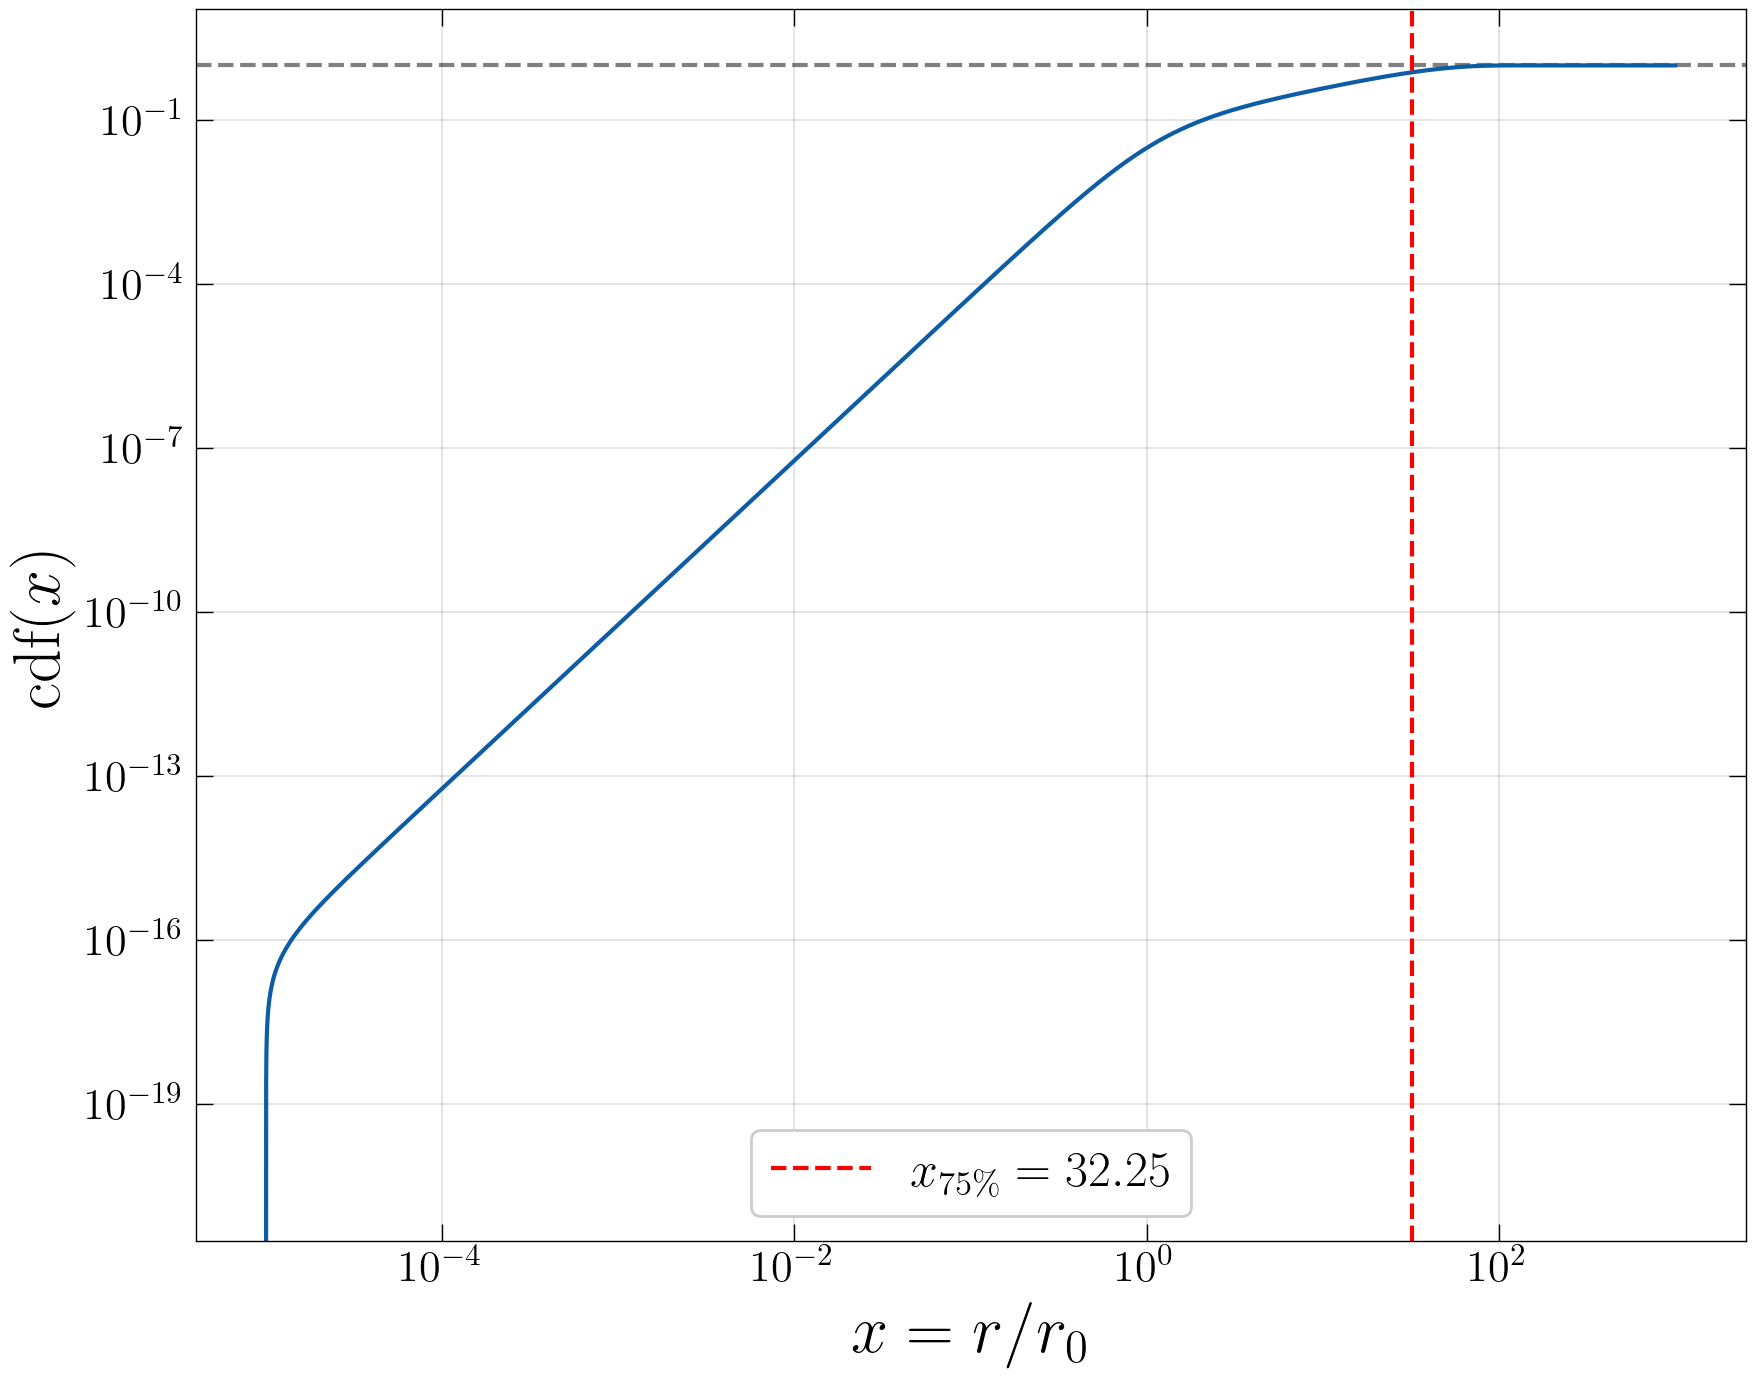

In [6]:
dx = np.roll(x, -1)[:-1] - x[:-1]
cdf = np.zeros_like(pdf)
for i in tqdm(range(len(dx))):
    cdf[i+1] = cdf[i] + pdf[i] * dx[i]

# It may be necessary to tweak the tolerance of np.isclose() to find one and only one solution
x_75quantile = x[np.isclose(cdf, 0.75, rtol=1e-5)][0]

plt.plot(x, cdf)
plt.axhline(1, color='gray', linestyle='--', zorder=0)
plt.axvline(x_75quantile, color='red', linestyle='--', label=f'$x_{{75\%}} = {x_75quantile:.2f}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x = r / r_0$')
plt.ylabel('cdf$(x)$')
plt.legend();

We define $r_0$ such that the 75% quantile of the radial pdf corresponds to 5 internal units.

King radius r_0: 0.1551 iu


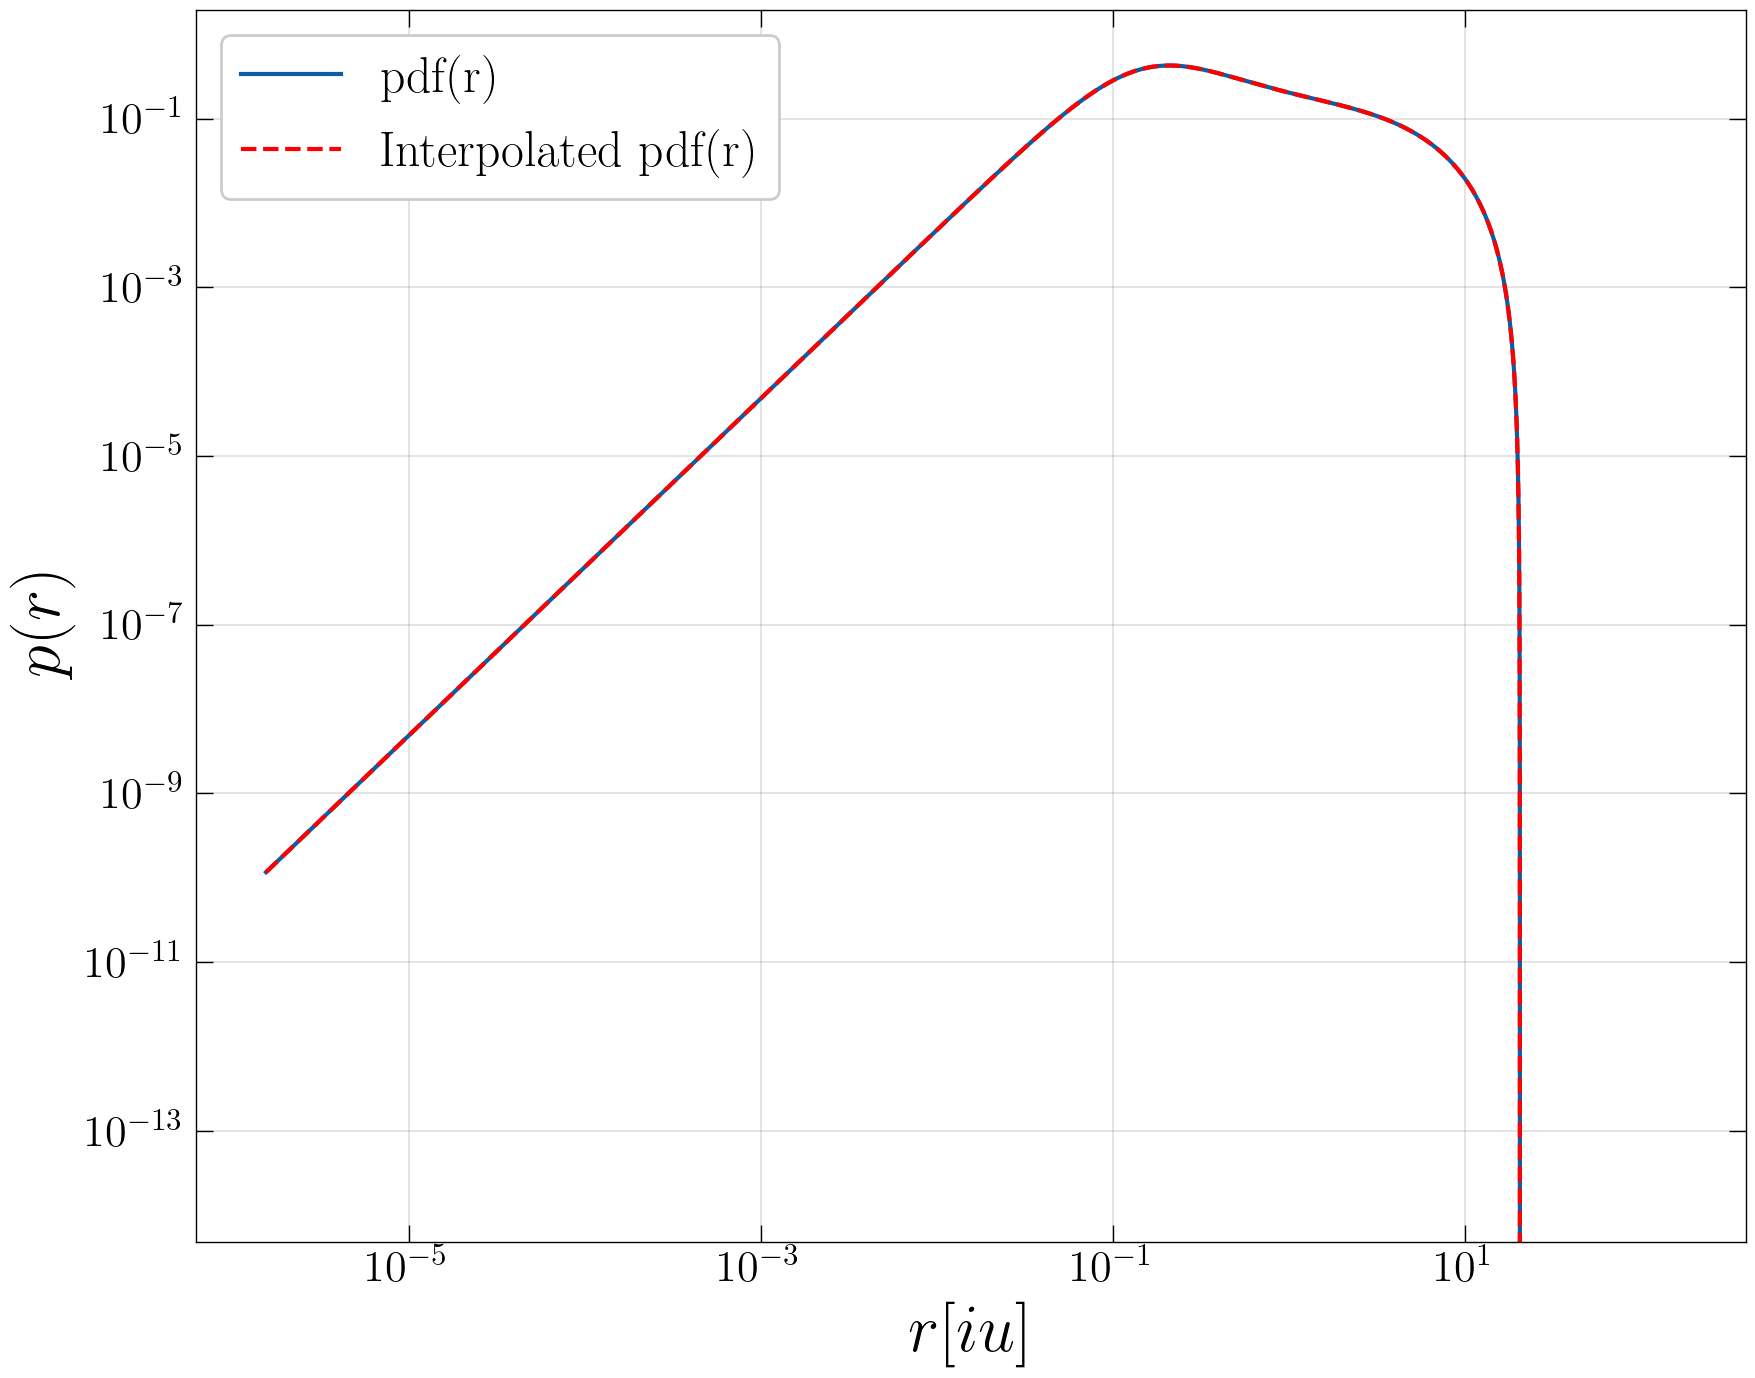

In [7]:
from scipy.interpolate import CubicSpline

r_0 = 5/x_75quantile
print(f'King radius r_0: {r_0:.4f} iu')

# Rescale x according to the King radius, obtaining an array of radii in internal units
r_dense = r_0 * x  

# Recompute the radial pdf
pdf = r_dense**2 * dimensionless_rho
normalization = simps(pdf, r_dense)
pdf /= normalization 

# Interpolate the pdf to be able to evaluate it at any radius
pdf_interp = CubicSpline(r_dense, pdf)

plt.plot(r_dense, pdf, label='pdf(r)')
plt.plot(r_dense, pdf_interp(r_dense), color='red', ls='--', label='Interpolated pdf(r)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r[iu]$')
plt.ylabel('$p(r)$')
plt.legend();

## 3) Velocities

The orientations can be sampled just like $\phi$ and $\theta$, but the magnitudes require more work.

The distribution of the velocity magnitudes is given by:
$$p(v|r) \, \propto \, f_\text{King}\left(\mathcal{E}(r,v)\right) v^2 dv \:\: ,$$ 
$$\textnormal{where} \:\:\:
f_\text{King}(\mathcal{E}(r,v)) \, = \, 
\begin{cases}
\rho_1 \left(2 \pi \sigma^2\right)^{-3/2} \left(e^{\mathcal{E}/\sigma^2} - 1\right) \, , &\mathcal{E}>0\\
0 \, , & \mathcal{E} \leq 0
\end{cases} \:\: ,
$$

where:
- $\mathcal{E} = \psi(r) - \frac{1}{2}v^2$ is the relative energy,
- $\psi(r) = \phi(r_\text{truncation}) - \phi(r)$ is the relative potential, such that $\psi(r_\text{truncation})=0$,
- $\sigma$ is a velocity scale parameter and is NOT the velocity dispersion,
- $\rho_1$ is a density scale parameter and is NOT the central density $\rho_0$.
</br></br>

The maximum allowed velocity is $v_\text{escape}(r)=\sqrt{-2\phi(r)}=\sqrt{2\psi(r)}$, since for our system to be at equilibrium it is necessary that it is bound.\
Hovewer, we only know the dimensionless potential $W(r) = \psi(r)/\sigma^2$ and thus we have to derive $\sigma$ first. This can be achieved by deriving $\rho_0$ first and then inverting the formula for $r_0$.\
Once we have done this, we can sample from:
$$p(v|x) \, \propto \, f_\text{King}(r,v) v^2 dv \:\: ,$$ 
$$\textnormal{where} \:\:\:
f_\text{King}(r,v) \, = \, 
\begin{cases}
\rho_1 \left(2 \pi \sigma^2\right)^{-3/2} \left(e^{\psi/\sigma^2 - v^2/2\sigma^2} - 1\right) \, , &v<\sqrt{2\psi(r)}\\
0 \, , & v \geq \sqrt{2\psi(r)}
\end{cases} \:\: ,
$$


Once the position is known, $\psi(r)$ is straightforward to evaluate from the interpolated potential profile.\
Since we do not know the analytical form of the potential, the direct-Montecarlo sampling method is not an option and we have to resort to the acceptance-rejection sampling method.
</br></br>

The idea is:
- Given the sampled position, compute $\psi(r)$;
- Generate the trial velocity $v \in \left[0, v_\text{escape}(r)\right]$;
- Evaluate $v^2 f_\text{King}(r,v)$ at the sampled position and velocity;
- Generate a random number $u \in \left[0, f_\text{max}\right]$;
- Accept the sampled velocity if $u < v^2 f_\text{King}(r,v)$.

# Code

## 1) Units

In [8]:
G_pu = 6.67430e-8             # cm^3 g^-1 s^-2
r_pu = 3.08567758128e18*1e3   # kpc in cm
m_pu = 1.989e33*1e7           # 10^7 M_sun in g

v_pu = np.sqrt(G_pu * m_pu / r_pu) #cm/s

time_pu = r_pu/v_pu #seconds

E_pu = G_pu*(m_pu**2)/r_pu #cm^2 g s^-2 = erg

In [9]:
v_pu = v_pu/1e5 #km/s
print(f"v_pu/v_iu = {v_pu:.2f} (km/s)/iu")

time_pu = time_pu/(3.156e7*1e6) #megayears
print(f"time_pu/time_iu = {time_pu:.3f} Myr/iu")

print(f"E_pu/E_iu = {E_pu:.2e} erg/iu")

v_pu/v_iu = 6.56 (km/s)/iu
time_pu/time_iu = 149.063 Myr/iu
E_pu/E_iu = 8.56e+51 erg/iu


In [10]:
N = int(5e4+2) # Number of particles
M = 1e4        # Total mass
m = M/(N-2)    # Mass of the single particles

## 2) Positions

Sample in spherical coordinates by using the direct Monte Carlo method

In [11]:
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Sample the radius by using the acceptance-rejection Monte Carlo method.\
It is preferable to have a sampler function that can be sampled through the Direct Monte Carlo method, like an exponential.

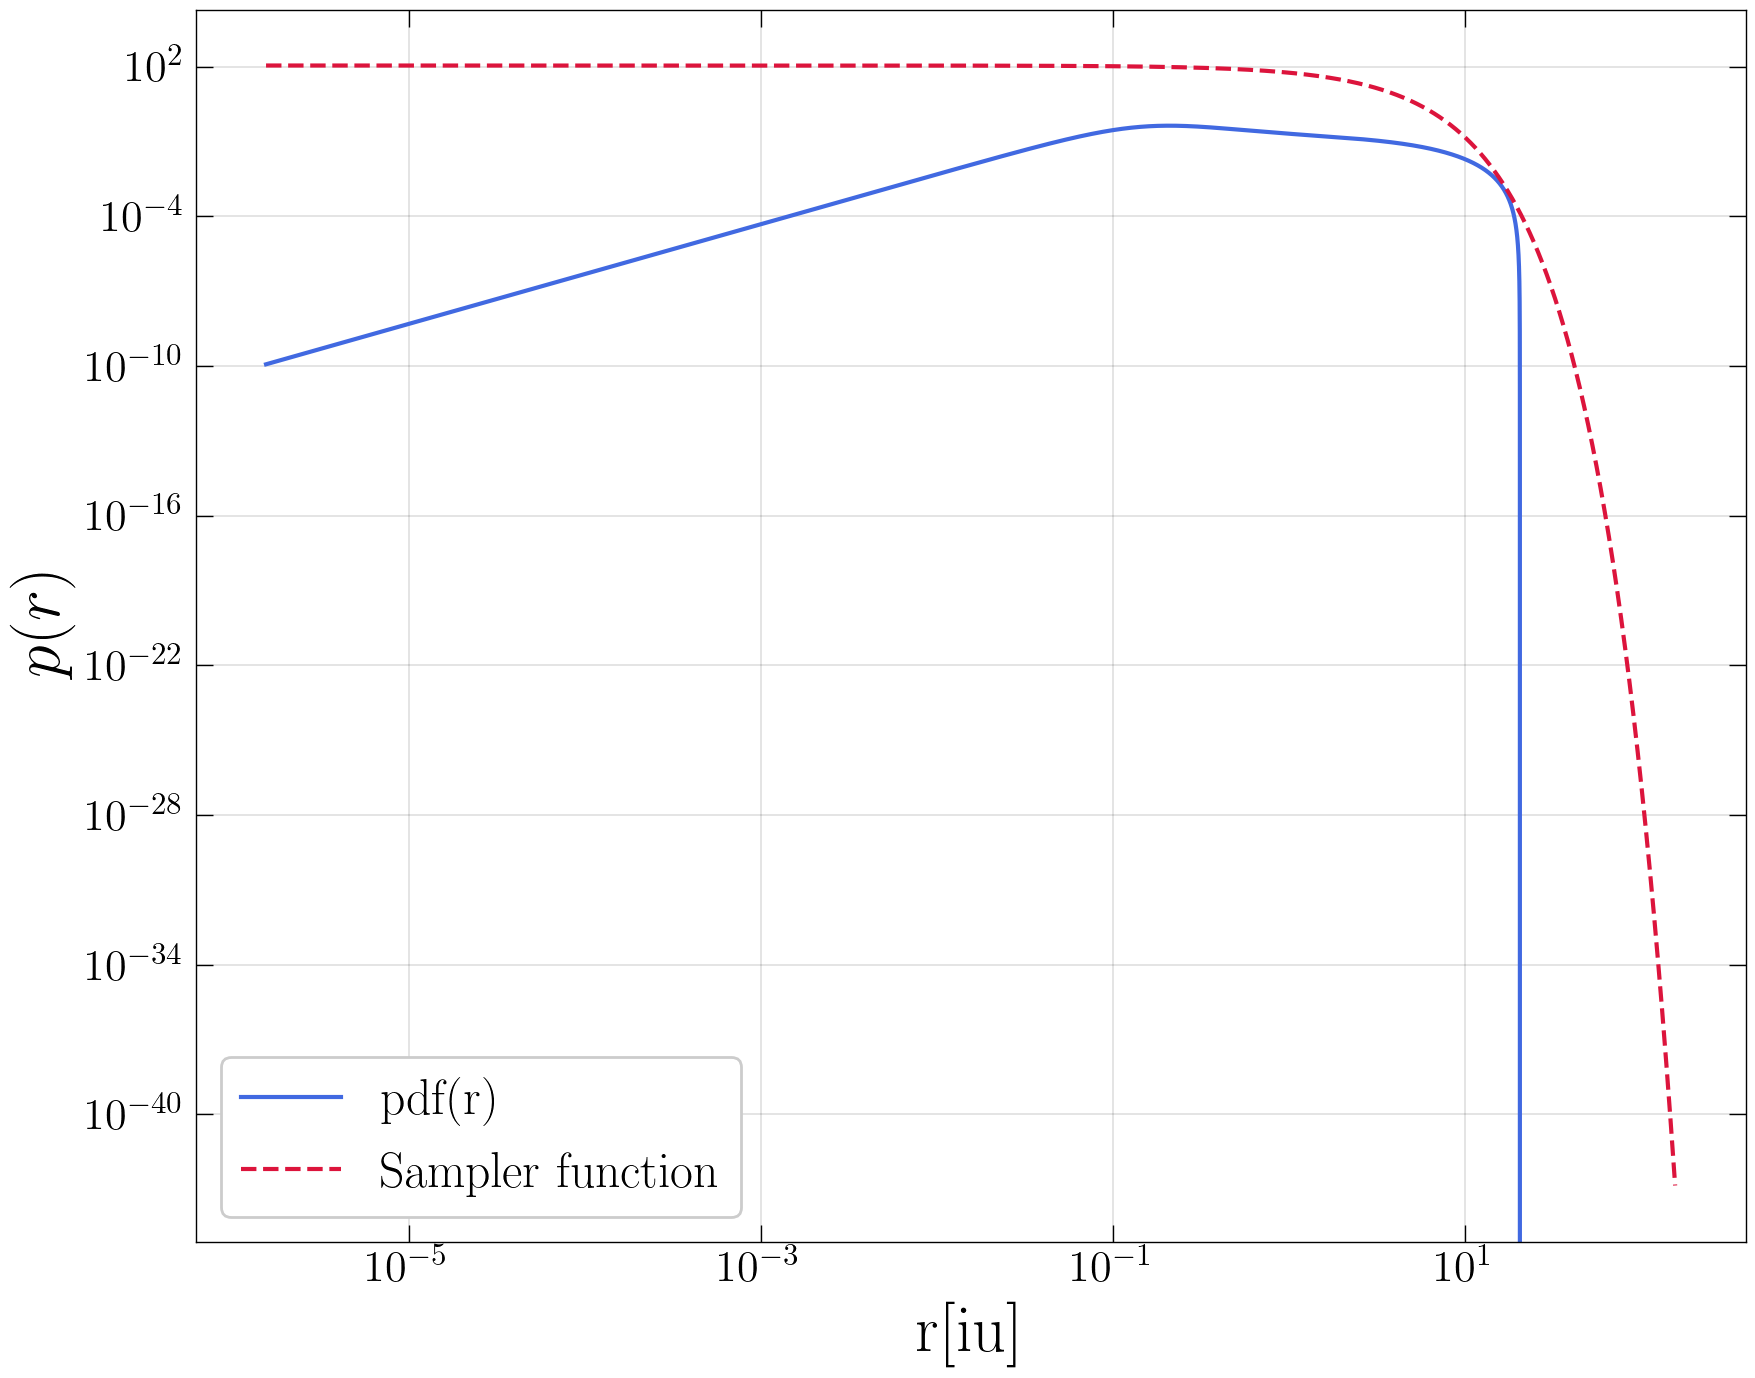

In [12]:
R = 1.5
sampler_normalization = 110

def sampler(x):
    return sampler_normalization * np.exp(-x/R)

plt.plot(r_dense, pdf_interp(r_dense), color='royalblue', label='pdf(r)')
plt.plot(r_dense, sampler(r_dense), ls='--', color='crimson', label='Sampler function')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r[iu]')
plt.ylabel('$p(r)$')
plt.legend();

In [13]:
# We split the loop into batches to increase efficiency by using vectorized operations.
def AcceptanceRejection(N, f_model, f_sampler, batch_size=100):
    samples = []
    
    while len(samples) < N:
        # To increase efficiency, we sample from the sampler distribution using the inverse transform sampling method.
        # Beware that the sampler distribution is not normalized, and thus its "cumulative" is not confined to 1, but to sampler_normalization * R
        u = np.random.uniform(0, sampler_normalization * R, batch_size)
        x = -R * np.log(1 - u / (sampler_normalization * R))
        
        y = np.random.uniform(0, f_sampler(x))
        mask = y <= f_model(x)
        
        accepted = x[mask]
        samples.extend(accepted.tolist())
        
        print(f"Accepted: {len(samples)}/{N}", end='\r')
        
    return np.array(samples)[:N]

r = AcceptanceRejection(N=N, f_model=pdf_interp, f_sampler=sampler)

Transform from spherical coordinates to Cartesian coordinates

In [14]:
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

Check the *pdfs*

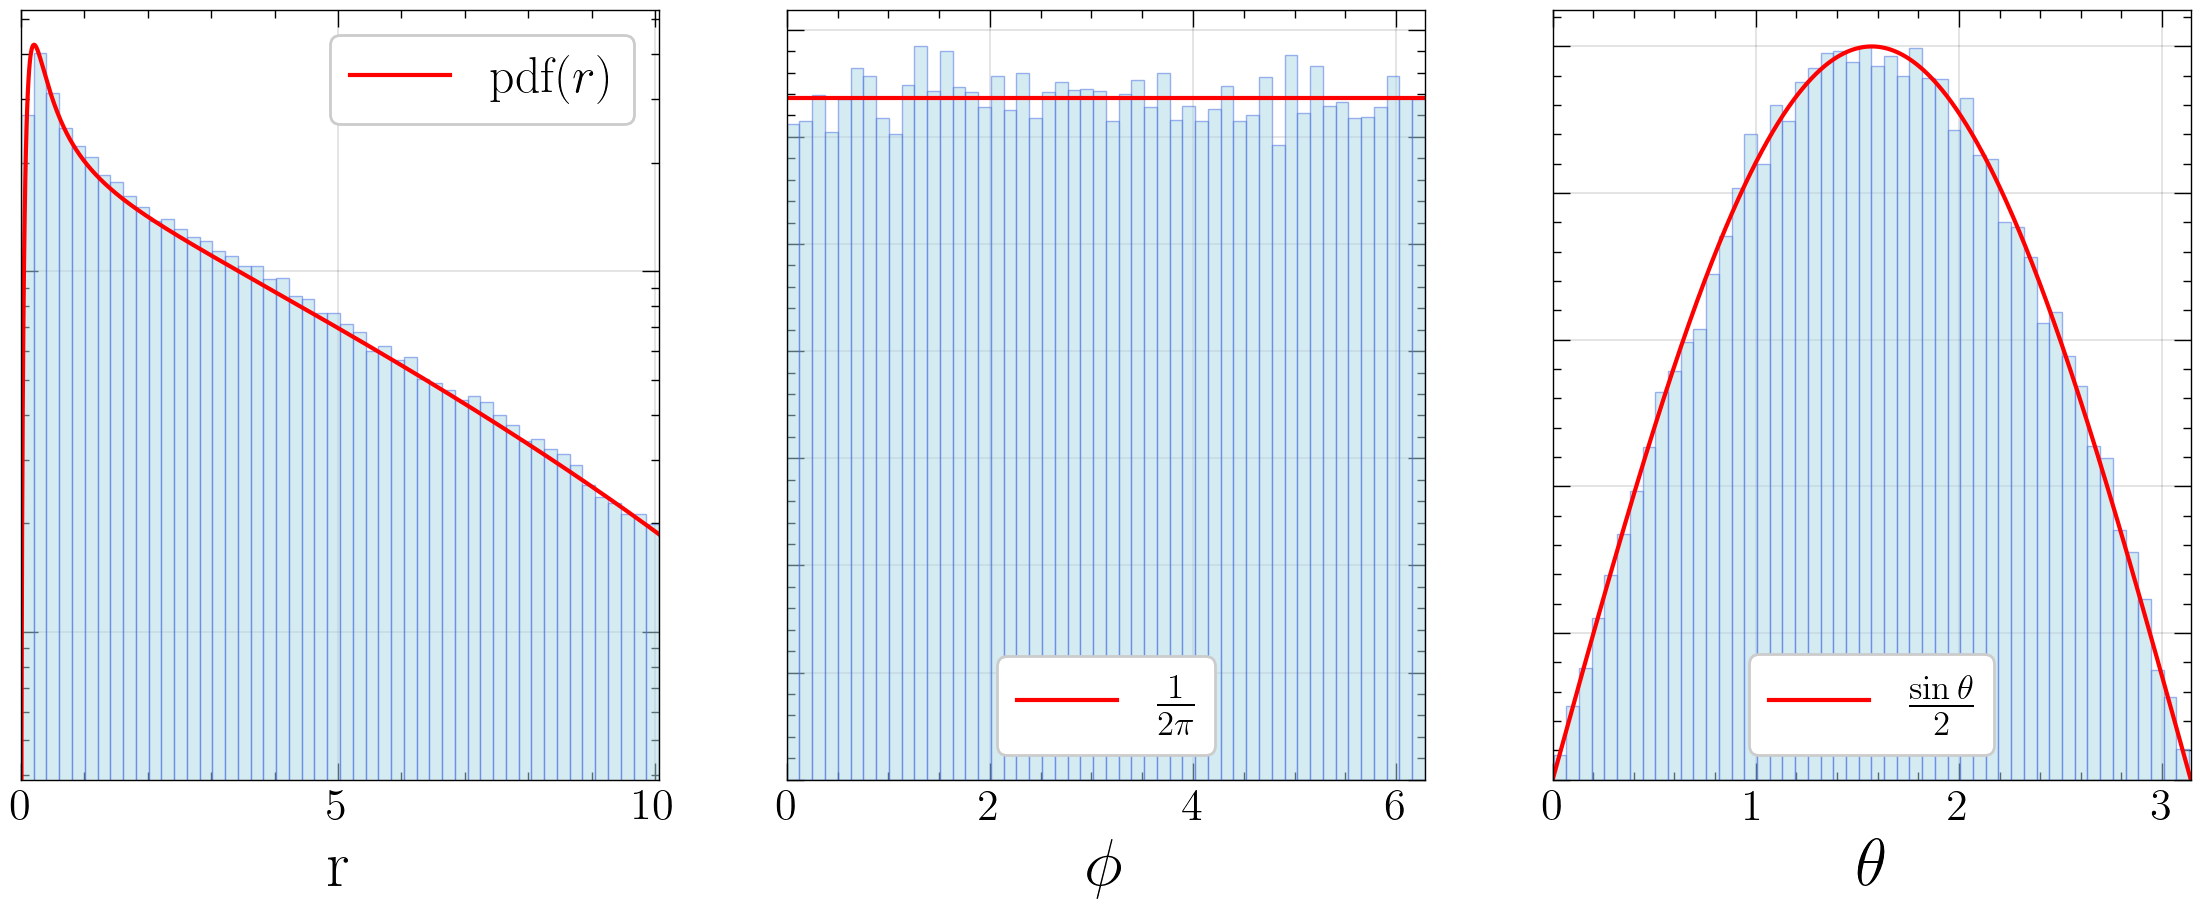

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14,5))

r_max_plot = np.quantile(r, 0.95)
ax = axes[0]
ax.hist(r[r<r_max_plot], bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, r_max_plot, 1000)
ax.plot(x_dense, pdf_interp(x_dense), color='red', label='pdf$(r)$')
ax.set_xlim(0, r_max_plot)
ax.set_yscale('log')
ax.set_xlabel('r')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[1]
ax.hist(phi, bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, 2*np.pi, 1000)
ax.axhline(1/(2*np.pi), color='red', label='$\\frac{1}{2\pi}$')
ax.set_xlim(0, 2*np.pi)
ax.set_xlabel('$\phi$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[2]
ax.hist(theta, bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, np.pi, 1000)
ax.plot(x_dense, 0.5*np.sin(x_dense), color='red', label='$\\frac{\sin{\\theta}}{2}$')
ax.set_xlim(0, np.pi)
ax.set_xlabel('$\\theta$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend();

## 3) Add the MBHs and set their initial positions

Since the mass of the perturber must satisfy $M \gg M_{pert} \gg m$, we choose it such that $\frac{M}{M_{pert}} = \frac{M_{pert}}{m}$

$
\begin{cases}
      M = \alpha M_{pert}\\
      M_{pert} = \alpha m\\
      M = mN
\end{cases}
\: \iff \:
\alpha = \dfrac{M}{\sqrt{N}}
$ 

In [16]:
#M_pert = M/np.sqrt(N)
M_pert = (1/100)*M
print(f'M_perturber = {M_pert:.3f}')
print(f'M / M_perturber  = {M/M_pert:.1f}')
print(f'M_perturber / m = {M_pert/m:.1f}')

M_perturber = 100.000
M / M_perturber  = 100.0
M_perturber / m = 500.0


We have to create an array for the masses

In [17]:
masses = m*np.ones(N)
masses[-1] = M_pert
masses[-2] = M_pert

We set the initial position of the perturber such that $r_{pert,0} = {\rm{quantile}}(r; 75\%)$

In [18]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    #The following looks more elegant, but it is less memory-efficient, especially for large arrays
    #return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x[:-2], y[:-2], z[:-2], 0, 0, 0) # It is equal to the array r[:-2]

CMpos_vector = np.array([np.sum(x[:-2]), np.sum(x[:-2]), np.sum(x[:-2])])/(N-2)
CMpos = np.linalg.norm(CMpos_vector)
print(f'CM position = {CMpos:.3f}')

CM position = 0.008


In [19]:
mask = dist_particle<np.quantile(dist_particle, 0.9)
CMpos_q90_vector = np.array([np.sum(x[:-2][mask]), np.sum(y[:-2][mask]), np.sum(z[:-2][mask])])/(N-2)
CMpos_q90 = np.linalg.norm(CMpos_q90_vector)
print(f'CM position 90% = {CMpos_q90:.3f}')

dist_pert = np.quantile(dist_particle, 0.75)
print(f'r_perturber = {dist_pert:.3f}')
print(f'r_perturber - CM position 90% = {dist_pert-CMpos_q90:.3f}')

CM position 90% = 0.010
r_perturber = 4.978
r_perturber - CM position 90% = 4.968


In [20]:
x[-1] = dist_pert
y[-1] = 0
z[-1] = 0

In [21]:
x[-2] = -dist_pert
y[-2] = 0
z[-2] = 0

## 4) Derive the velocity scale parameter $\sigma$

Now that we set a scale for our King distribution by imposing a particular $r_0$, we would like to determine $\rho_0$.

We know the profile of $\tilde{\rho}(r) = \rho(r)/\rho_0$ and we can compute $\rho(r) = \dfrac{M_\text{tot} p(r)}{4 \pi r^2} \:\:,$ so we can compare them to estimate $\rho_0$.

In [22]:
rho = M * pdf / (4 * np.pi * r_dense**2) 

mask = rho > 0
index_truncation = np.argmin(rho[mask])
r_truncation = r_dense[mask][index_truncation]
print(f"Truncation radius index: {index_truncation}")
print(f"Truncation radius: {r_truncation:.2f} iu")

Truncation radius index: 889815
Truncation radius: 20.37 iu


rho_0 = 38380.61 iu


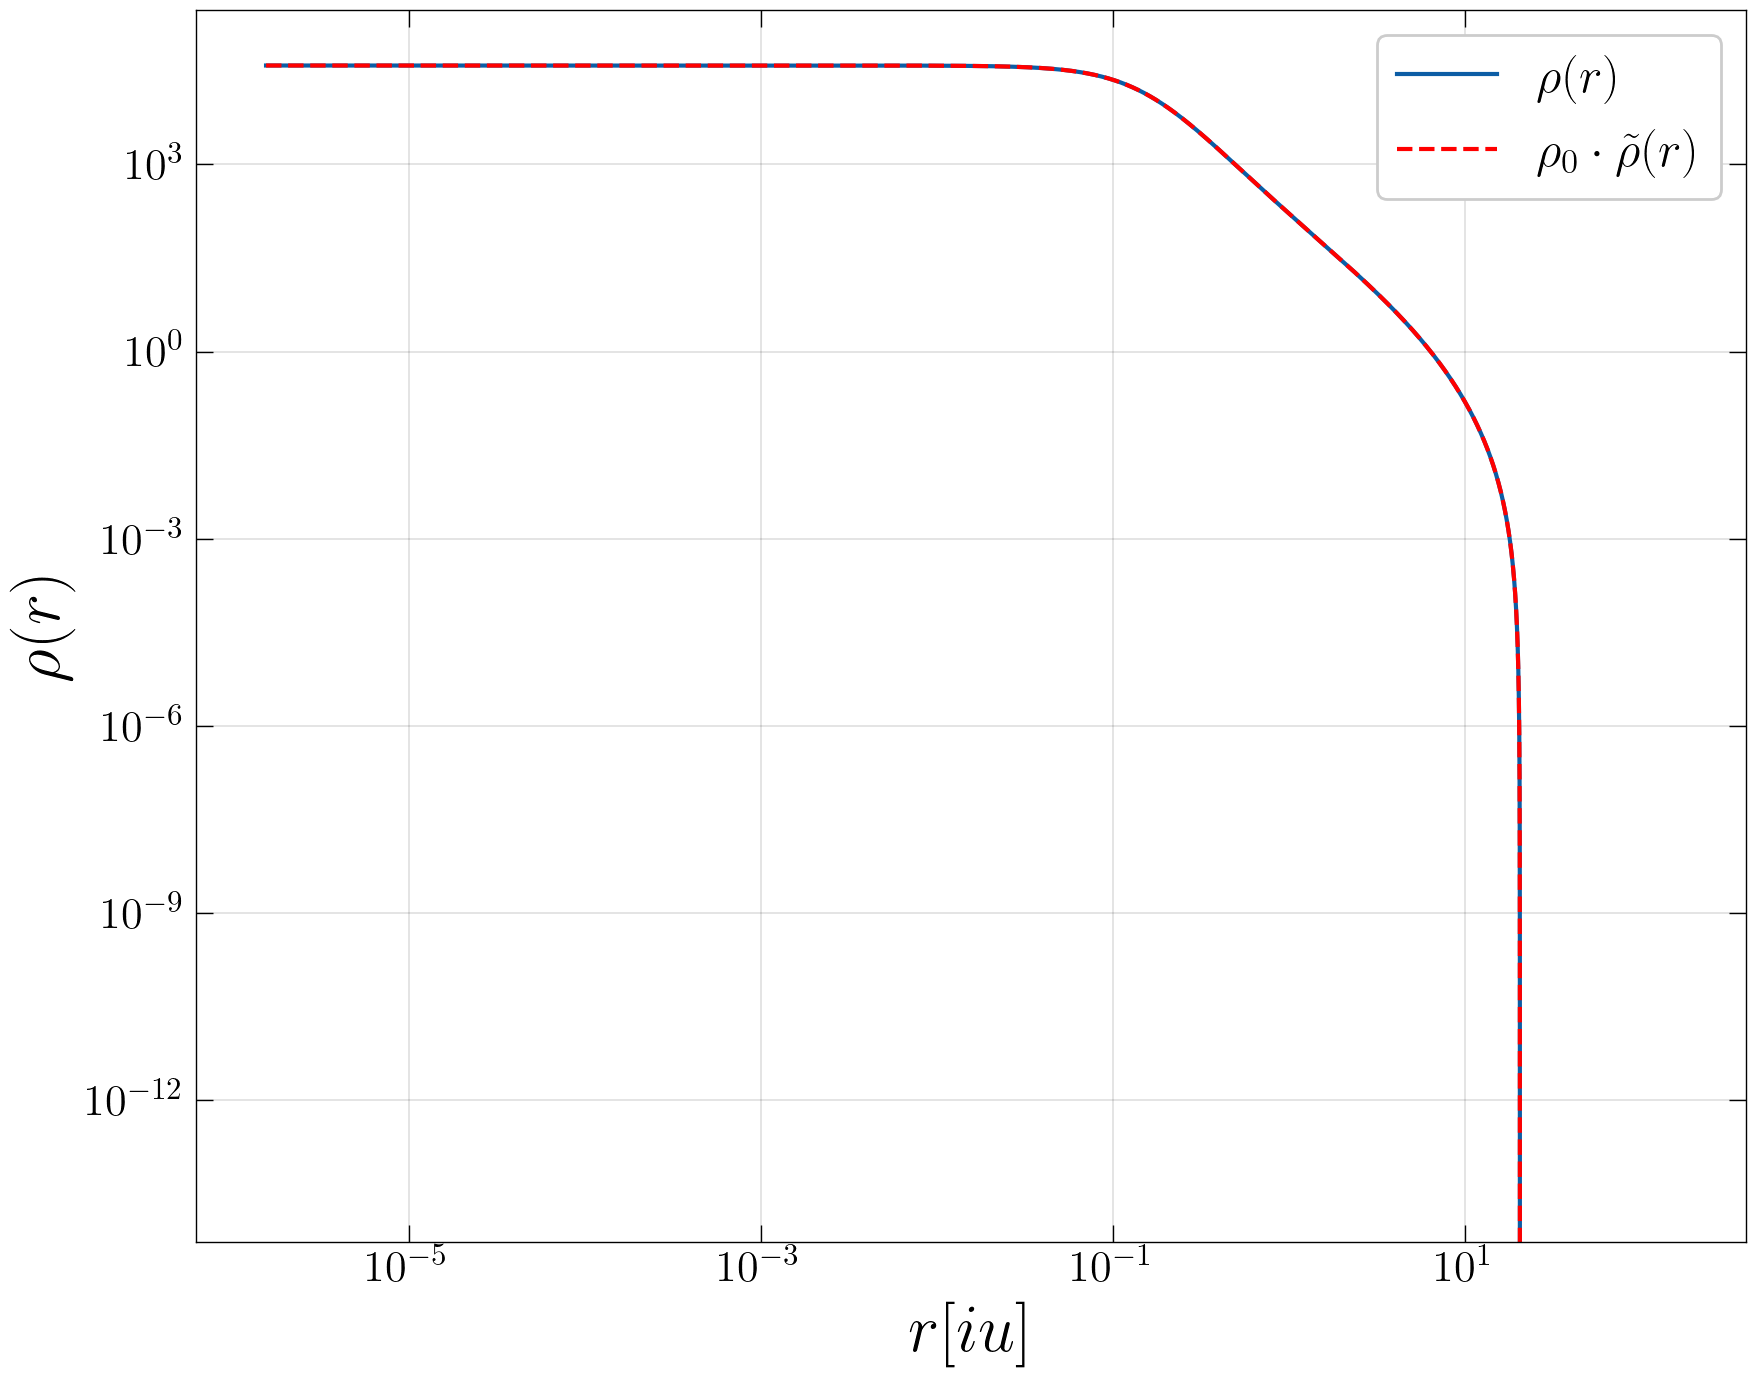

In [23]:
rho_0 = np.median(rho[:index_truncation]/dimensionless_rho[:index_truncation])
print(f"rho_0 = {rho_0:.2f} iu")

plt.plot(r_dense, rho, label='$\\rho(r)$')
plt.plot(r_dense, rho_0*dimensionless_rho, color='red', ls='--', label='$\\rho_0 \\cdot \\tilde{\\rho}(r)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r[iu]$')
plt.ylabel('$\\rho(r)$')
plt.legend();

We fixed $r_0$ and derived $\rho_0$. Now, we can finally obtain an estimate for $\sigma$.

In [24]:
sigma = np.sqrt(4 * np.pi * rho_0 * r_0**2 / 9)
print(f"Velocity scale parameter: {sigma:.2f} iu")

Velocity scale parameter: 35.90 iu


## 5) Velocities

Sample the angles by using the direct Monte Carlo method

In [25]:
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Sample $v$ by using the acceptance-rejection method

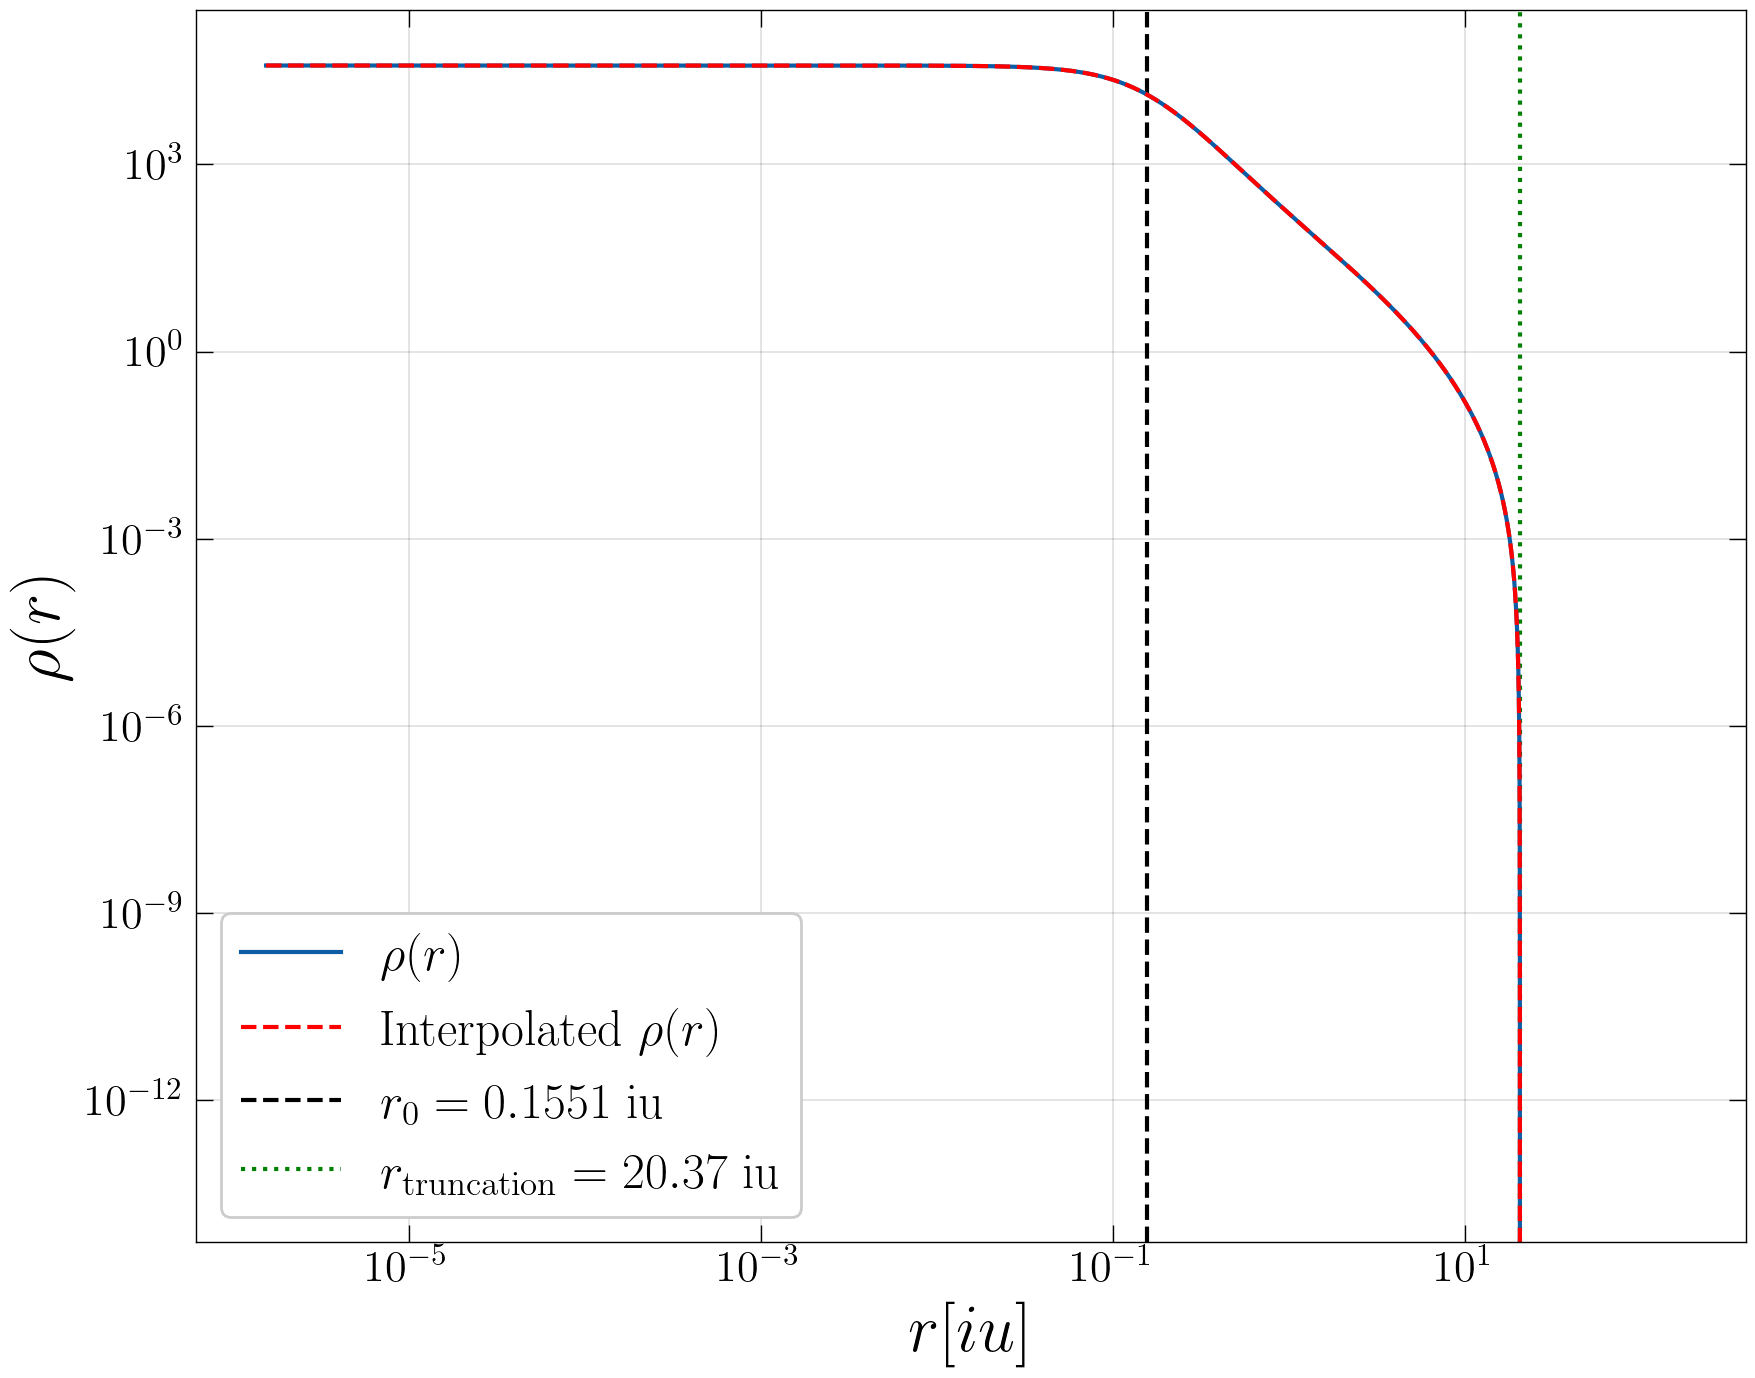

In [26]:
# Interpolate the density profile to be able to evaluate it at any radius
rho_interp = CubicSpline(r_dense, rho)

plt.plot(r_dense, rho, label='$\\rho(r)$')
plt.plot(r_dense, rho_interp(r_dense), color='red', ls='--', label='Interpolated $\\rho(r)$')
plt.axvline(r_0, color='black', ls='--', label=f'$r_0 = {r_0:.4f}$ iu', zorder=0)
plt.axvline(r_truncation, color='green', ls=':', label=f'$r_\\text{{truncation}} = {r_truncation:.2f}$ iu', zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r[iu]$')
plt.ylabel('$\\rho(r)$')
plt.legend();

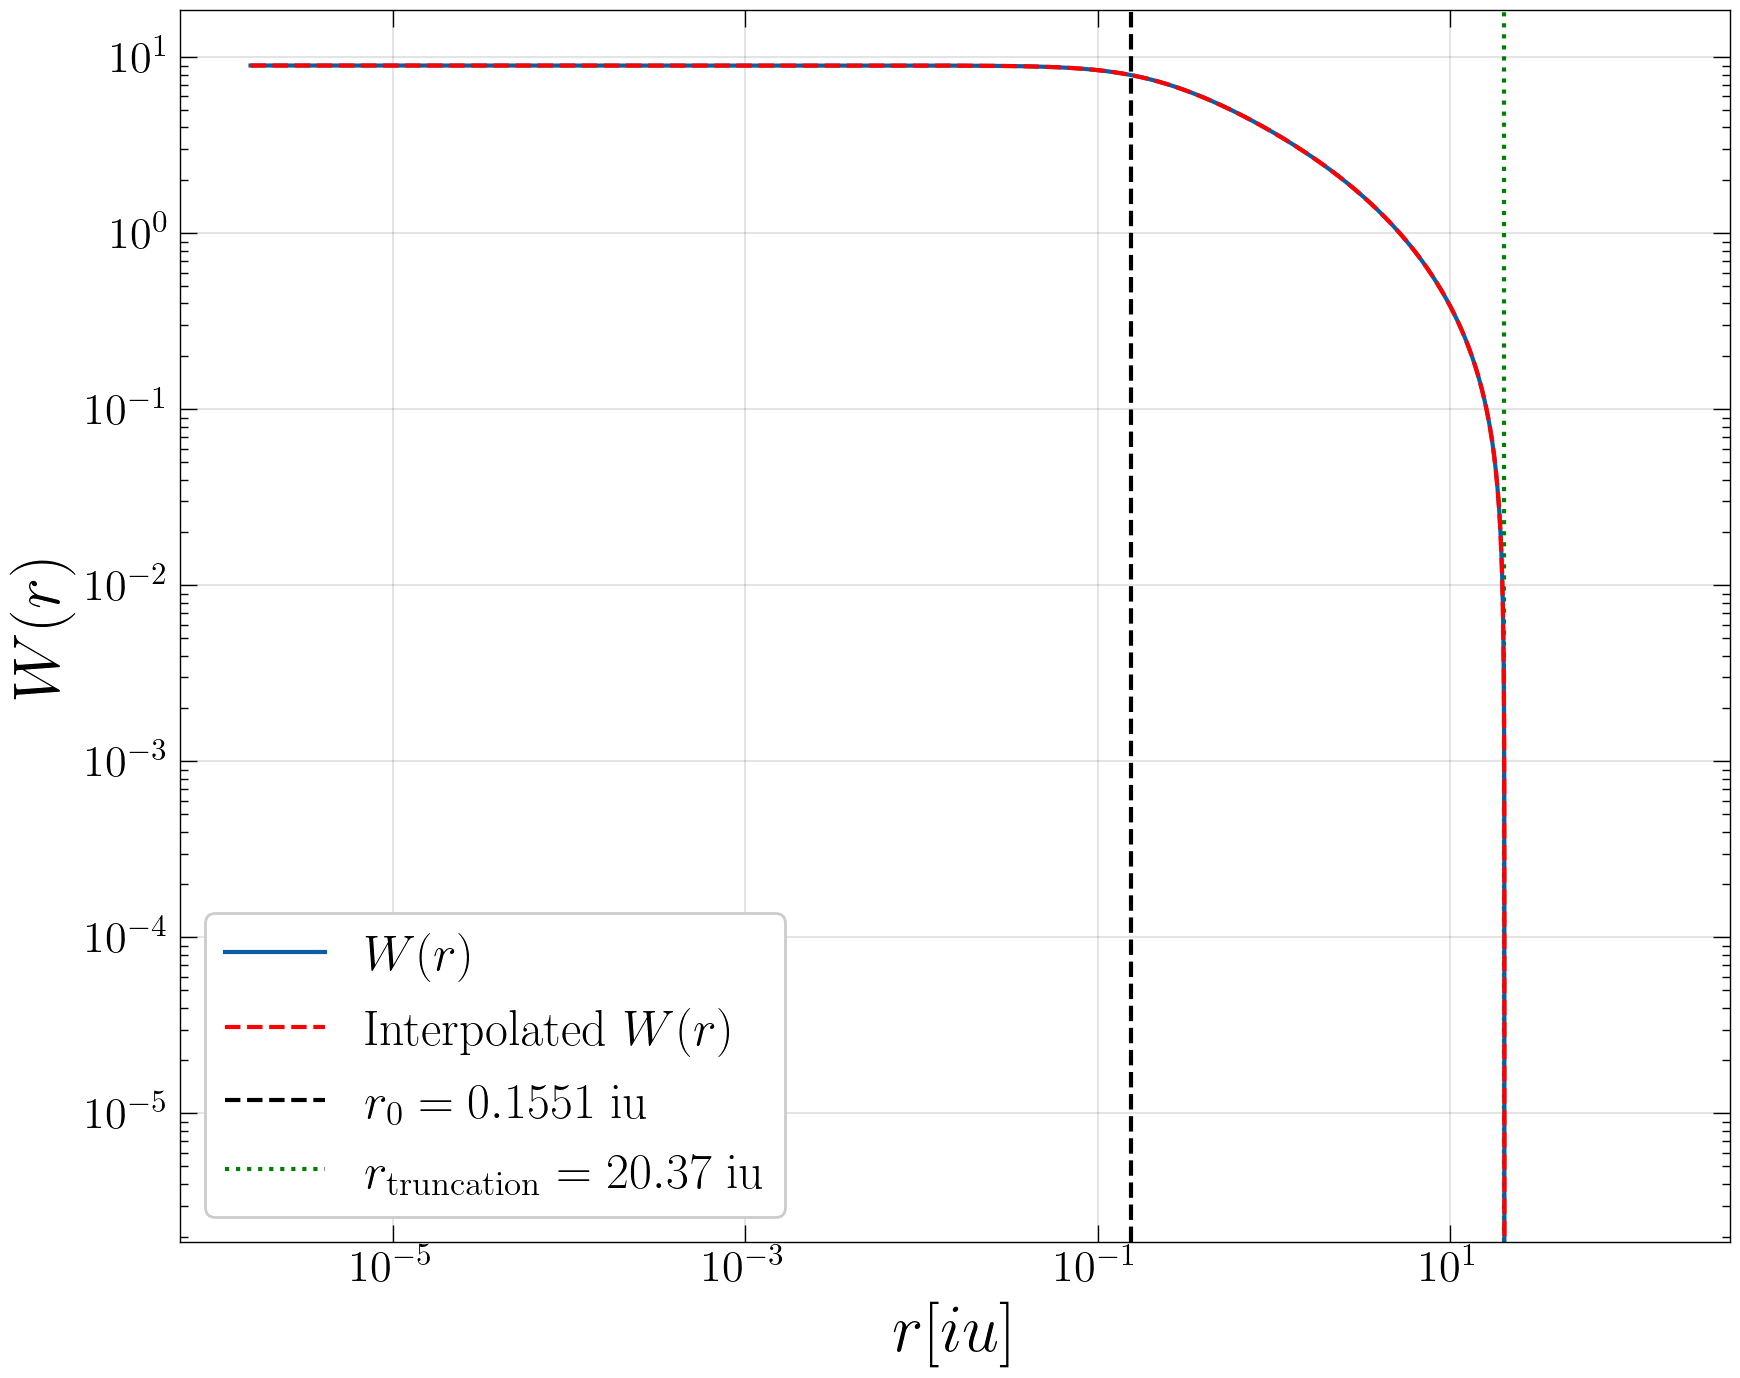

In [27]:
# Interpolate the potential profile to be able to evaluate it at any radius
W_interp = CubicSpline(r_dense, W)

plt.plot(r_dense, W, label='$W(r)$')
plt.plot(r_dense, W_interp(r_dense), color='red', ls='--', label='Interpolated $W(r)$')
plt.axvline(r_0, color='black', ls='--', label=f'$r_0 = {r_0:.4f}$ iu', zorder=0)
plt.axvline(r_truncation, color='green', ls=':', label=f'$r_\\text{{truncation}} = {r_truncation:.2f}$ iu', zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r[iu]$')
plt.ylabel('$W(r)$')
plt.legend();

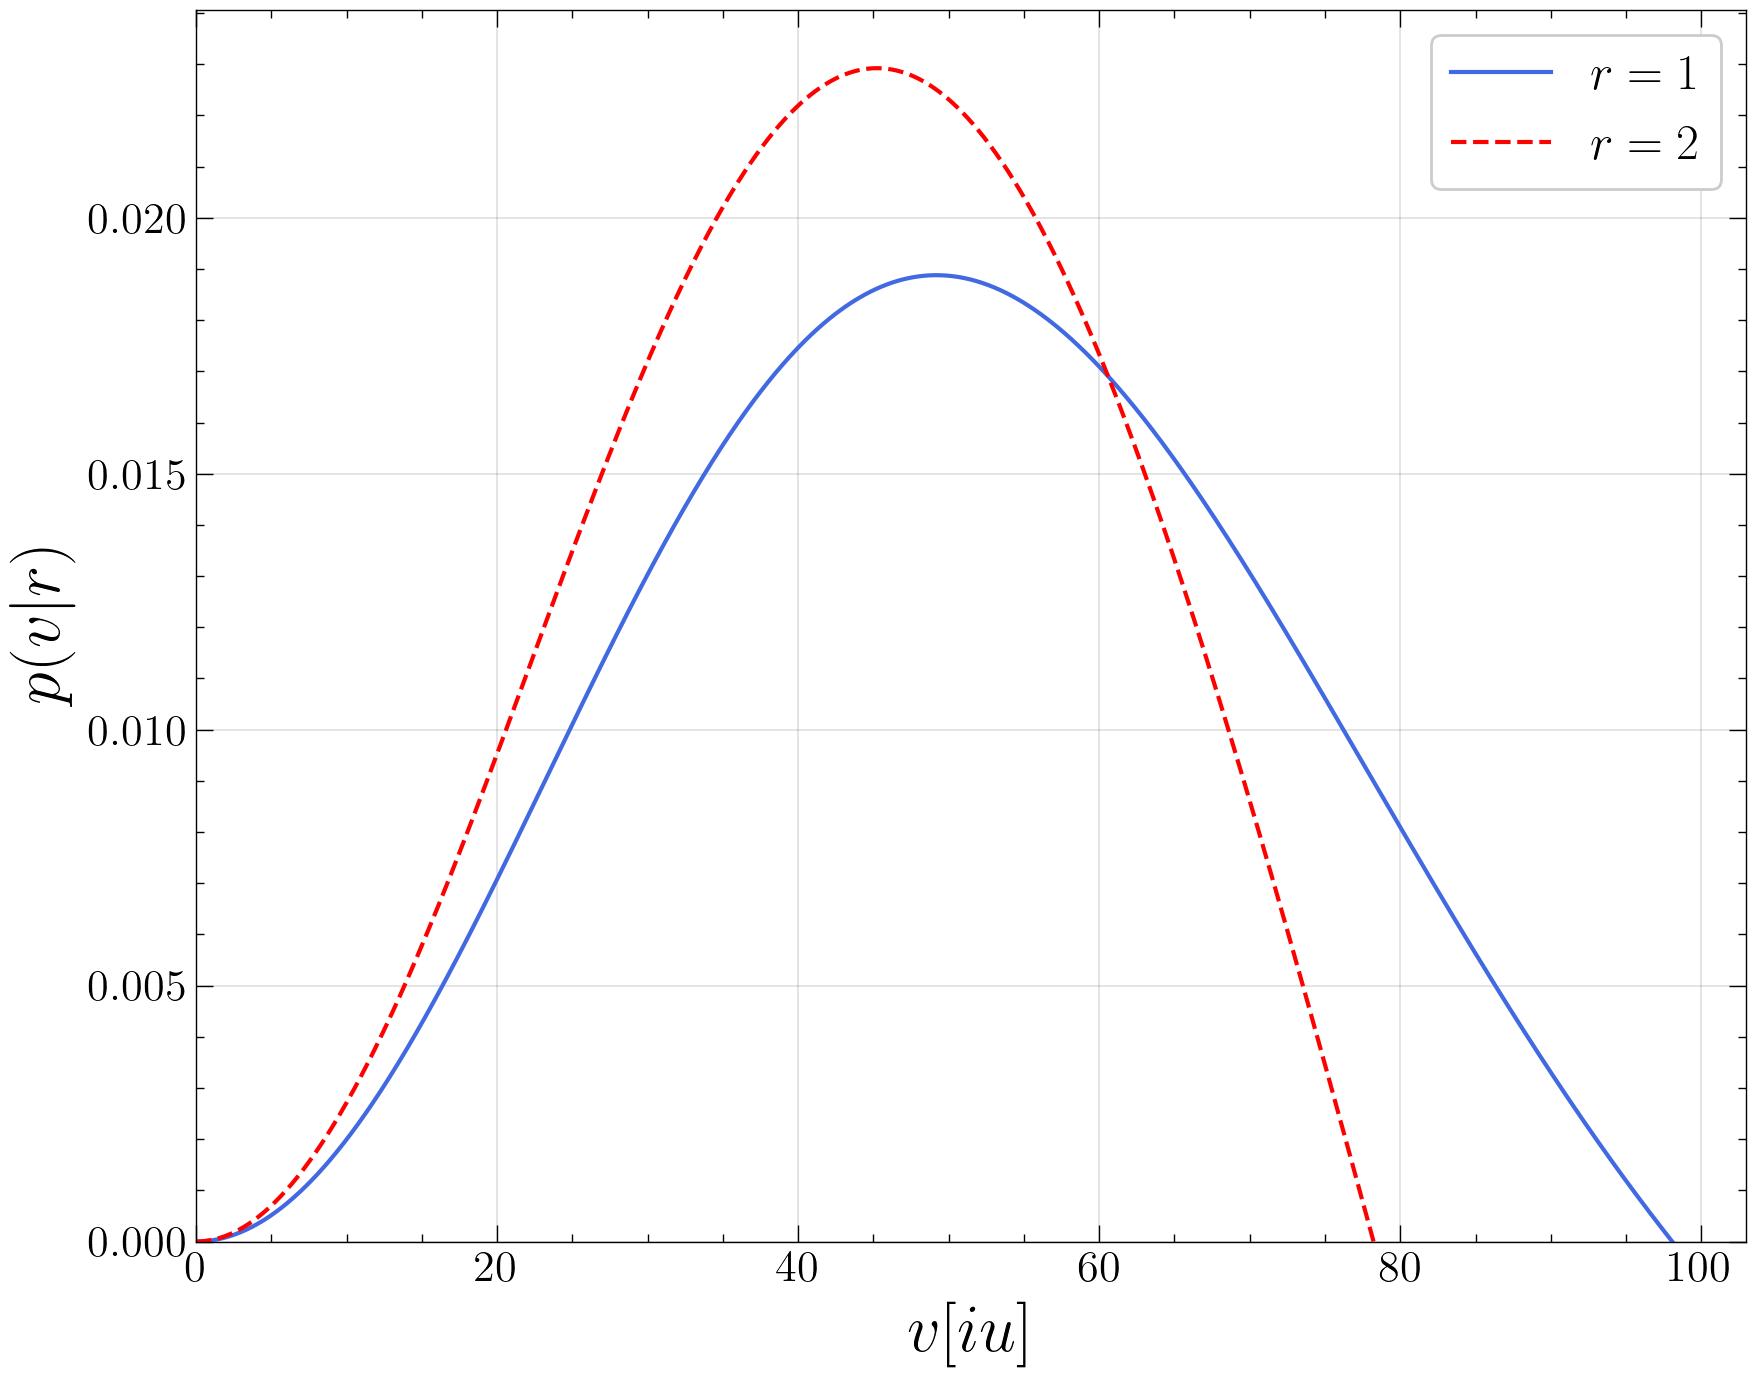

In [28]:
def v_escape(r):
    return np.sqrt(2*(W_interp(r)*sigma**2))

def f_of_v(v, r=1):
    rho_1 = rho_0 / Dimensionless_density(W0)
    C_norm = rho_1 * (2 * np.pi * sigma**2)**(-3/2)
    return C_norm * (np.exp(W_interp(r) - v**2/(2*sigma**2)) - 1)

def p_of_v(v, r=1):
    return 4*np.pi*v**2 * f_of_v(v, r) / rho_interp(r)

r_trial = 1
v_dense = np.linspace(0, v_escape(r_trial), 1000)
plt.plot(v_dense, p_of_v(v_dense, r_trial), color='royalblue', label='$r=1$')

r_trial2 = 2
v_dense2 = np.linspace(0, v_escape(r_trial2), 1000)
plt.plot(v_dense2, p_of_v(v_dense2, r_trial2), color='red', ls='--', label='$r=2$')

plt.xlim(0)
plt.ylim(0)
plt.xlabel('$v[iu]$')
plt.ylabel('$p(v|r)$')
plt.legend();

In [29]:
v = np.zeros(N)

W_array = W_interp(r)
v_escape_array = v_escape(r)

for i in tqdm(range(N)):
    while v[i] == 0:
        v_dense = np.linspace(0, v_escape_array[i], 1000)
        v_trial = np.random.uniform(0, v_escape_array[i])
        p_trial = p_of_v(v_trial, r[i])
        
        p_max = np.max(p_of_v(v_dense, r[i]))
        u_trial = np.random.uniform(0, 1.1*p_max)
        
        if u_trial < p_trial:
            v[i] = v_trial

100%|██████████| 50002/50002 [00:04<00:00, 10101.03it/s]


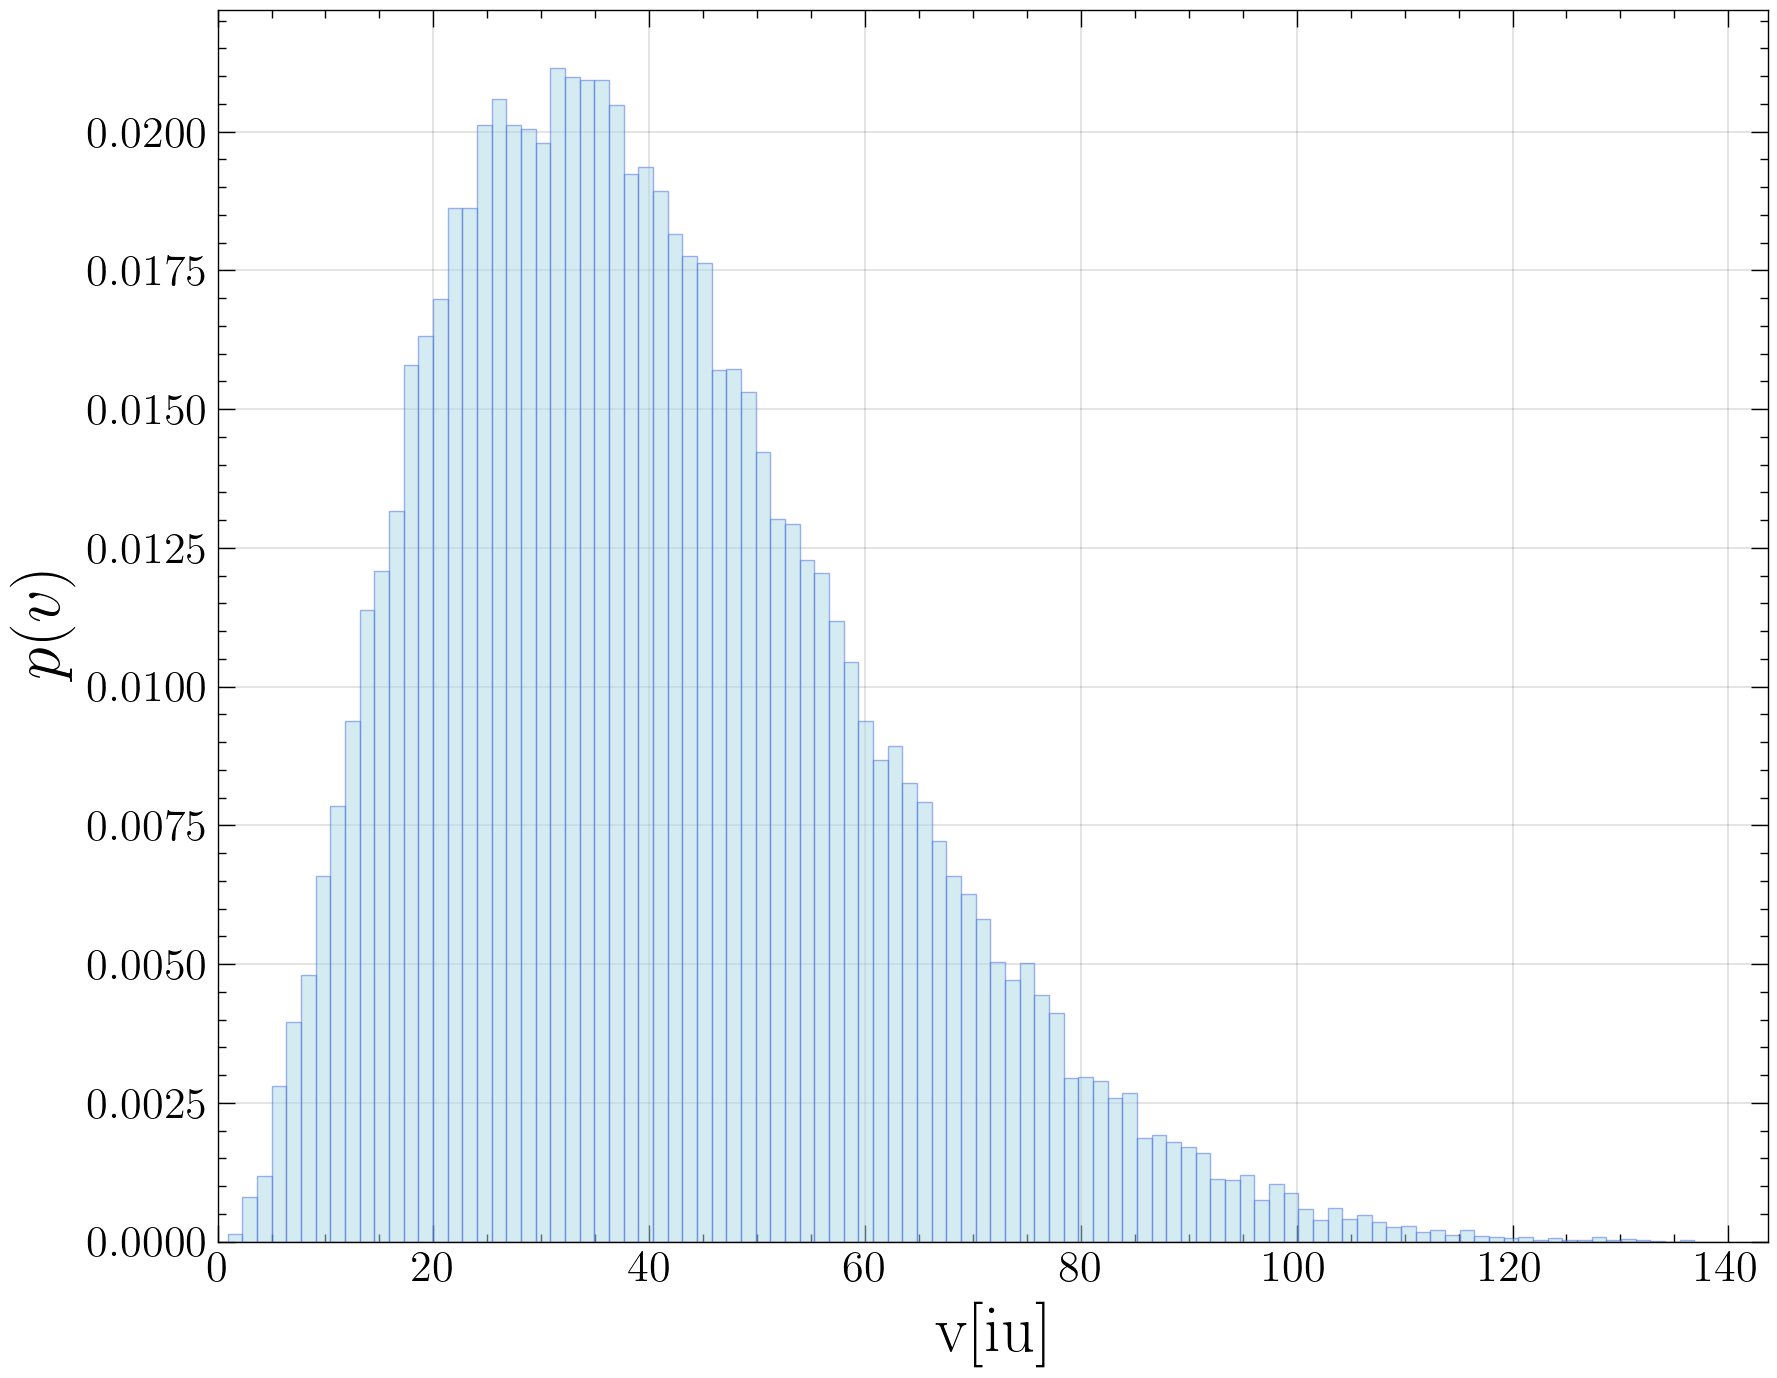

In [30]:
plt.hist(v, bins=100, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
plt.xlim(0)
plt.xlabel('v[iu]')
plt.ylabel('$p(v)$');

We can plot the median velocity as a function of radius

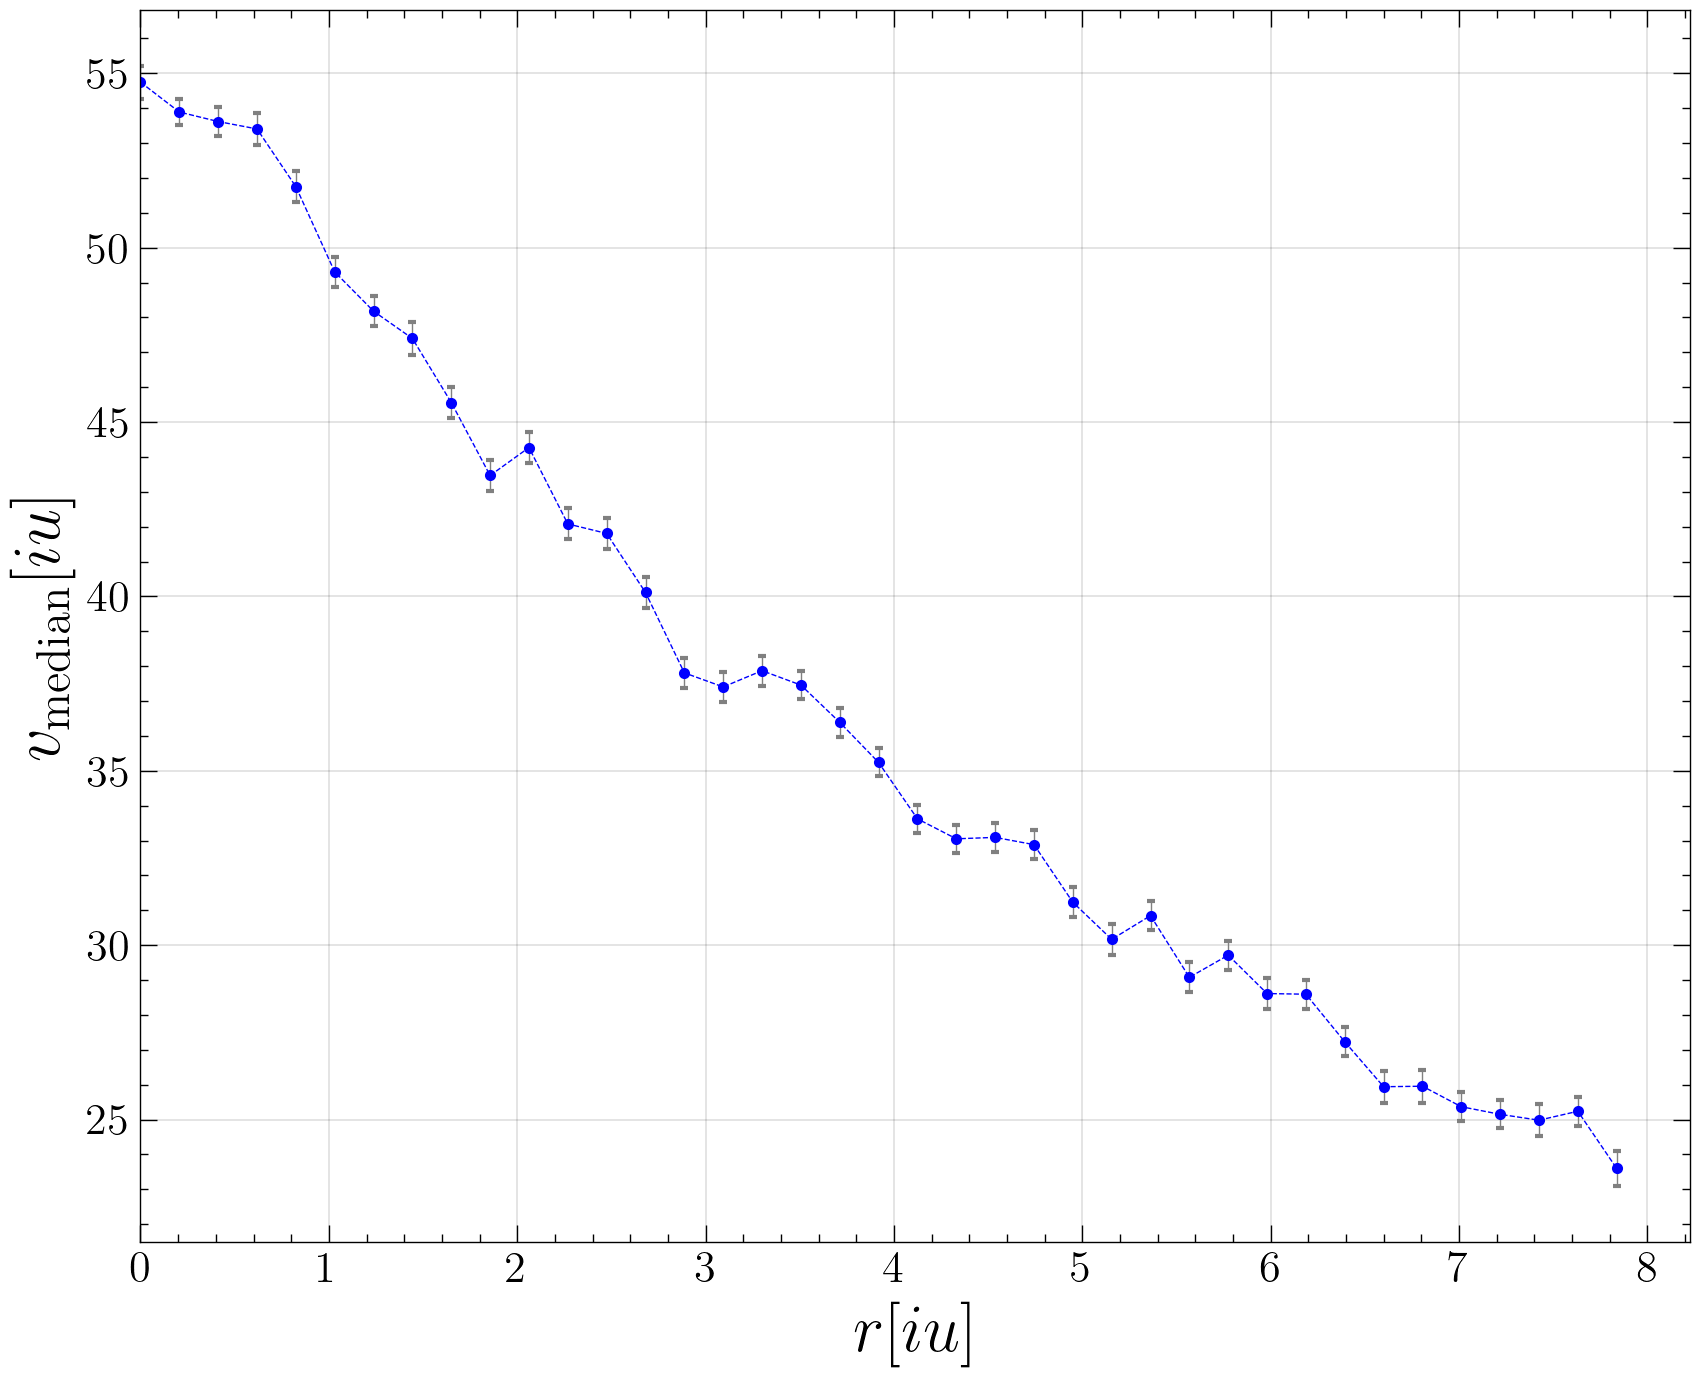

In [31]:
# Redefine the distance from the CM, neglecting the 10% further particles
dist_particle = Dist(x[:-2], y[:-2], z[:-2], CMpos_q90_vector[0], CMpos_q90_vector[1], CMpos_q90_vector[2])

# Define radial bins
r_bins = np.linspace(0, np.quantile(dist_particle, 0.9), 40)

# Compute the median velocity in each radial bin
v_bins = np.zeros_like(r_bins)
v_bins_err = np.zeros_like(r_bins)
for i in range(len(r_bins)-1):
    mask = np.logical_and(dist_particle >= r_bins[i], dist_particle < r_bins[i+1])
    v_bins[i] = np.median(v[:-2][mask])
    v_bins_err[i] = 0.74*(np.quantile(v[:-2][mask], 0.75) - np.quantile(v[:-2][mask], 0.25))/ np.sqrt(np.sum(mask))
    
# Plot the results
plt.errorbar(r_bins[:-1], v_bins[:-1], yerr=v_bins_err[:-1], fmt='.', color='blue', ecolor='grey', capsize=1.5, capthick=1.5, ls='--', lw=0.5)
plt.xlim(0)
plt.xlabel('$r[iu]$')
plt.ylabel('$v_\\text{median}[iu]$');

We can use the virial theorem to check the results

In [32]:
from scipy.spatial.distance import pdist

positions = np.stack((x[:-2], y[:-2], z[:-2]), axis=1)  # Shape (N-2, 3)
dists = pdist(positions)                                # Only unique pairs
U_tot = -m**2 * np.sum(1.0 / dists)

# Incredibly faster than
#U_tot = 0
#for i in tqdm(range(N-2)):
#    for j in range(i+1, N-2):
#        r_ij = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
#        U_tot += -m**2/r_ij

K_tot = 0
for i in tqdm(range(N)):
    K_tot += 0.5*masses[i]*v[i]**2  
        
print(K_tot/U_tot)

100%|██████████| 50002/50002 [00:00<00:00, 2029786.09it/s]

-0.5059213034069173


Transform from spherical coordinates to Cartesian coordinates

In [33]:
vx = v*np.sin(theta)*np.cos(phi)
vy = v*np.sin(theta)*np.sin(phi)
vz = v*np.cos(theta)

Let us redefine the velocities of the perturbers to have a more reproducible system

In [34]:
v_circ = np.sqrt(m*np.sum(dist_particle < x[-1]) / x[-1])
v_circ

38.81578199630744

In [35]:
vx[-1] = 0
vy[-1] = v_circ
vz[-1] = 0

print(x[-1], y[-1], z[-1])
print(vx[-1], vy[-1], vz[-1])

4.978147324447945 0.0 0.0
0.0 38.81578199630744 0.0


In [36]:
vx[-2] = 0
vy[-2] = 0
vz[-2] = v_circ

print(x[-2], y[-2], z[-2])
print(vx[-2], vy[-2], vz[-2])

-4.978147324447945 0.0 0.0
0.0 0.0 38.81578199630744


In [37]:
r_influence = M_pert/np.var(v)
print(f'r_influence = {1e3*r_influence:.1f} pc')

r_influence = 252.6 pc


## 5) Create the input file

In [38]:
# open the file
file = open('project.in', 'w')

# write the file
file.write(f'{N}\n')
file.write('3\n')
file.write('0\n')

for i in range(N):
    file.write(f'{masses[i]}\n')

for i in range(N):
    file.write(f'{x[i]} {y[i]} {z[i]}\n')
    
for i in range(N):
    file.write(f'{vx[i]} {vy[i]} {vz[i]}\n')

# close the file
file.close()

## 6) Numerical estimation of some parameters

### 6.1) Softening parameter

In [39]:
r_median = np.quantile(r, 0.5)
r_median

2.4074962132165676

In [40]:
V_at_r_median = (4/3)*np.pi*r_median**3
softening = (V_at_r_median/(N/2))**(1/3)
print(softening)

0.13272193020010992


### 6.2) Dynamical timescale

In [41]:
rho_mean = np.mean(rho)
print(f'rho_mean = {rho_mean:.3f}')

rho_mean = 23322.469


In [42]:
t_dyn = np.sqrt(3*np.pi/(16*rho_mean))
print(f't_dyn = {t_dyn:.4f}')

t_dyn = 0.0050
